# HTTPS Tunneling Binary Classification

### [dataset](https://www.kaggle.com/datasets/archie2023/https-tunneling-predictive-analysis-dataset)

Data Scientist: [Kevin Thomas](mailto:ket189@pitt.edu)

License: [MIT](https://www.mit.edu/~amini/LICENSE.md)

## **Executive Summary**

### **Objective**

This report presents the development and evaluation of a binary classification model designed to predict tunnel traffic (`is_tunnel_traffic`) within network traffic data. Utilizing a comprehensive dataset of network connections, the model aims to enhance early detection and resource allocation for managing tunnel traffic in network environments.

### **Data Insights**

**1. Continuous Variables Analysis**
- **Distribution Patterns:** Network traffic features, including UpBytes, DownBytes, TcpRtt, and Duration, exhibit extreme right skewness, with most values concentrated at lower ranges and few large outliers. TcpRtt and is_tunnel_traffic are similarly skewed, indicating rare but high-value instances common in network data.
- **Implications of Skewness:** The presence of outliers and skewed distributions may affect summary statistics, suggesting the need for transformations to improve visualization and model interpretation.

**2. Categorical Variables Analysis**
- **ServerPort and ClientPort Distributions:** ServerPort shows a dominant value, with most traffic using a single port, suggesting frequent use of a default or specific port. Conversely, ClientPort is more distributed, with a broader range of ports in use and some areas of higher concentration.
- **Top Port Usage:** ServerPort 443 is consistently accessed across various client ports, indicating its importance in network communication, with other server ports showing significantly lower access counts.

**3. Advanced Visualizations**
- **Interaction Heatmaps & Scatter Plots:** ServerPort 443 shows high interaction counts with multiple ClientPorts, highlighting its utilization in network communication. Scatter plots illustrate a linear trend between UpBytes and DownBytes across ports, with ServerPort 443 and active client ports engaging in larger data exchanges.
- **Box, Violin, and Line Plots:** Log-transformed visualizations reveal ServerPort 443's wide distribution and high outliers in metrics like UpBytes and Duration, indicating variability. ClientPorts are more consistent, showing moderate variability. Line plots of mean values highlight that ServerPorts demonstrate distinct usage patterns, with more variability compared to ClientPorts.

### **Model Development and Selection**

**Model Evaluation**
- **Model 1:** `is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration` - Exhibited the highest ROC AUC (0.752) and stable performance, with an average accuracy of 0.874. Its simplicity and lack of interactions avoid overflow issues and provide reliable discrimination between tunnel and non-tunnel traffic.
- **Model 2:** `is_tunnel_traffic ~ UpBytes + DownBytes * TcpRtt + Duration` - Displayed instability due to interaction terms, resulting in overflow warnings and a lower ROC AUC of 0.724.
- **Model 3:** `is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt * Duration` - Also experienced instability with interactions, leading to overflow issues and the lowest ROC AUC of 0.689.

**Best Model Selection:** Model 1 was chosen for its balance of simplicity, stability, and optimal ROC AUC, making it the most effective for classifying tunnel traffic in this dataset.

### **Implications**

The selected Model 1 demonstrates robust performance with high accuracy and discriminative ability, making it suitable for deployment in tunnel traffic detection. Its simplicity enhances generalizability to new data, which is essential for real-world applications in network monitoring and security.

### **Recommendations and Next Steps**

1. **Address Skewness and Outliers:** Implement transformations or alternative visualizations to better capture the range of values and improve feature scaling.
2. **Feature Engineering:** Explore additional features or interaction terms selectively, ensuring stability to enhance model performance.
3. **Class Imbalance Mitigation:** Address class imbalance in tunnel versus non-tunnel traffic by resampling or adjusting algorithm parameters.
4. **Deployment and Monitoring:** Integrate the model into network monitoring systems for real-time tunnel traffic detection and track its performance for continuous improvement.

### **Conclusion**

Through comprehensive data analysis and model selection, a stable and effective tunnel traffic prediction model has been developed. By refining features and managing data distribution challenges, this model holds potential for improved traffic management and network security strategies.

## Import Main Modules & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import pickle

In [3]:
# with open('HTPA/normal_traffic.pickle', 'rb') as f:
#     normal_traffic_list = pickle.load(f)

In [4]:
# with open('HTPA/tunnel_traffic.pickle', 'rb') as f:
#     tunnel_traffic_list = pickle.load(f)

## Convert Lists to Datasets & Concat Datasets

In [5]:
# normal_traffic_df = pd.DataFrame(normal_traffic_list)

In [6]:
# normal_traffic_df.shape

In [7]:
# normal_traffic_df.dtypes

In [8]:
# tunnel_traffic_df = pd.DataFrame(tunnel_traffic_list)

In [9]:
# tunnel_traffic_df.shape

In [10]:
# tunnel_traffic_df.dtypes

## Create Binary Target Variable: 1 for `is_tunnel_traffic`, 0 Everything Else

In [11]:
# normal_traffic_df['is_tunnel_traffic'] = 0

In [12]:
# tunnel_traffic_df['is_tunnel_traffic'] = 1

In [13]:
# combined_df = pd.concat([normal_traffic_df, tunnel_traffic_df], ignore_index=True)

## Perform Basic Analysis

In [14]:
# combined_df.shape

In [15]:
# combined_df.dtypes

## Verify/Handle Missing Values 

In [16]:
# combined_df.isna().sum()

In [17]:
# combined_df_copy = combined_df.copy()

In [18]:
# combined_df_copy = combined_df_copy.dropna()

## Drop Initial Irrelevant Variables

In [19]:
# df = df.drop(columns=['SizeSeq', 'TimeSeq'])

## Save the Dataset to a `.csv`

In [20]:
# combined_df_copy.to_csv('https_normal_tunneling.csv', index=False)

## Load the Saved Dataset

In [21]:
import zipfile

In [22]:
# specify the path to the zip file
zip_file_path = 'https_normal_tunneling.csv.zip'

# unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts to the current directory

# echo success
print('File unzipped successfully.')

File unzipped successfully.


In [23]:
df = pd.read_csv('https_normal_tunneling.csv')

## Drop Irrelevant Variables

In [24]:
df = df.drop(columns=['ServerIP',
                      'ClientIP',
                      'Domain',
                      'UpPackets',
                      'DownPackets'])

## Treat `ServerPort` and `ClientPort` as a Categorical Column

In [25]:
df['ServerPort'] = df['ServerPort'].astype('category')

In [26]:
df['ClientPort'] = df['ClientPort'].astype('category')

## Create `Duration` and Drop `StartTime` and `EndTime` to Avoid Strong Multicollinearity

In [27]:
df['Duration'] = df['EndTime'] - df['StartTime']

In [28]:
df = df.drop(columns=['StartTime', 'EndTime'])

## Perform Basic Analysis - Cleaned Dataset

In [29]:
df.shape

(1325458, 7)

In [30]:
df.dtypes

ServerPort           category
ClientPort           category
UpBytes                 int64
DownBytes               int64
TcpRtt                float64
is_tunnel_traffic       int64
Duration              float64
dtype: object

In [31]:
df.isna().sum()

ServerPort           0
ClientPort           0
UpBytes              0
DownBytes            0
TcpRtt               0
is_tunnel_traffic    0
Duration             0
dtype: int64

In [32]:
df.is_tunnel_traffic.value_counts()

is_tunnel_traffic
0    1154322
1     171136
Name: count, dtype: int64

In [33]:
_ = [print(f'{df[column].value_counts()}\n') for column in df.columns]

ServerPort
443      1134897
40001      12699
40002      12105
4032       12006
3041       10506
          ...   
61001          2
20227          2
20225          2
20224          2
30027          2
Name: count, Length: 250, dtype: int64

ClientPort
61000    179
49888    124
50968    124
49786    121
49932    118
        ... 
29114      1
29113      1
29112      1
29107      1
2          1
Name: count, Length: 58323, dtype: int64

UpBytes
798       9222
718       8387
802       8192
717       7261
597       6206
          ... 
34061        1
73122        1
113439       1
46294        1
31134        1
Name: count, Length: 43852, dtype: int64

DownBytes
4978      13544
0         10118
7596       7843
3100       7600
7597       7312
          ...  
129093        1
94225         1
45780         1
73285         1
114323        1
Name: count, Length: 93464, dtype: int64

TcpRtt
0.000015    404
0.000010    368
0.000020    332
0.000005    267
0.000025    240
           ... 
0.019612      1
0.01

In [34]:
df.nunique()

ServerPort              250
ClientPort            58323
UpBytes               43852
DownBytes             93464
TcpRtt               253786
is_tunnel_traffic         2
Duration             966447
dtype: int64

## Visualize the Marginal Distributions

### Continuous Variables: Histograms and Density Plots
* The provided histograms display the distribution of several network traffic features, including UpBytes, DownBytes, TcpRtt, is_tunnel_traffic, and Duration. All variables show a highly skewed distribution, with the majority of data concentrated at the lower values. UpBytes, DownBytes, and Duration display extreme right skewness, indicating that most of the observed values are low, with a few very large outliers. TcpRtt and is_tunnel_traffic are similarly skewed, with most observations near zero. This skewness suggests the presence of rare but large values, typical in network traffic data, potentially affecting summary statistics and necessitating transformations or alternative visualization techniques for clearer insights.

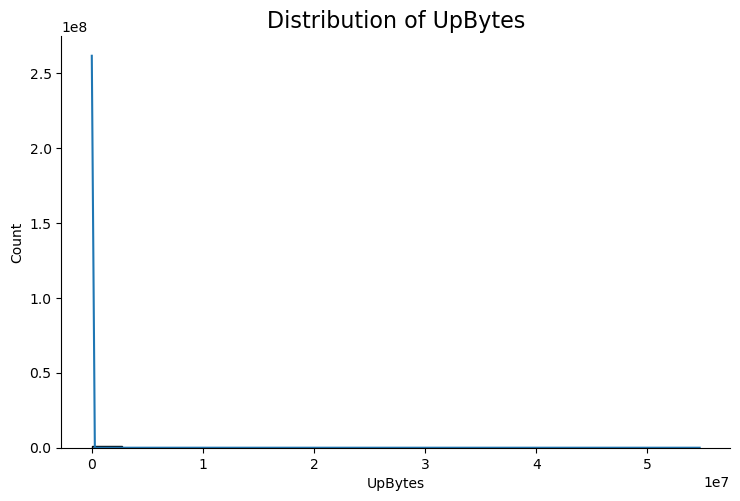

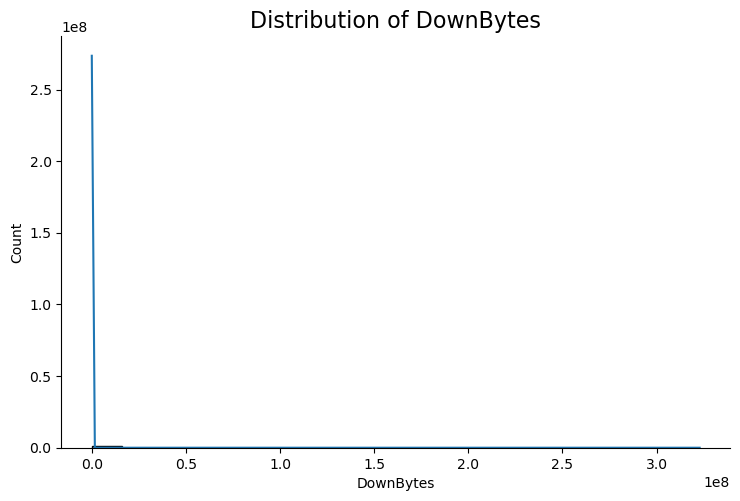

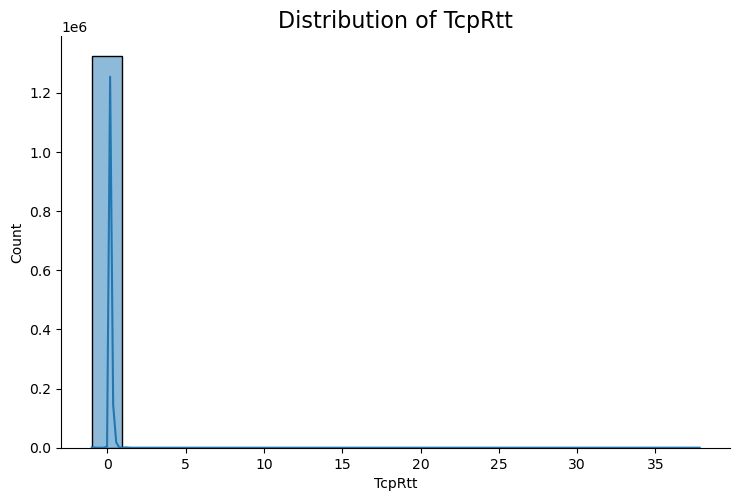

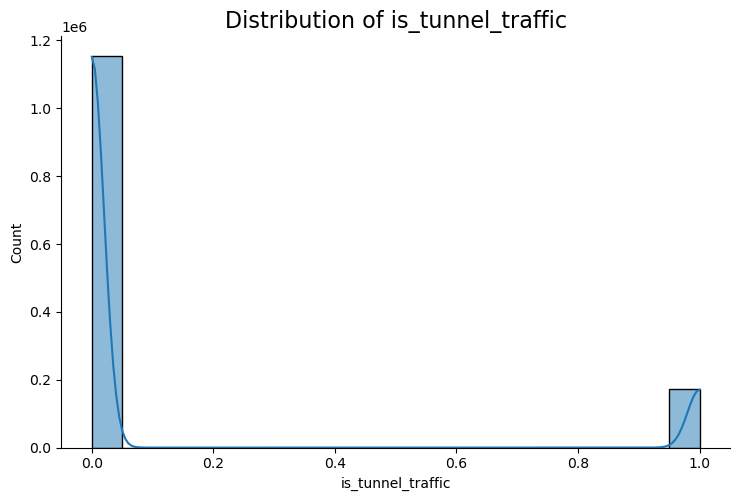

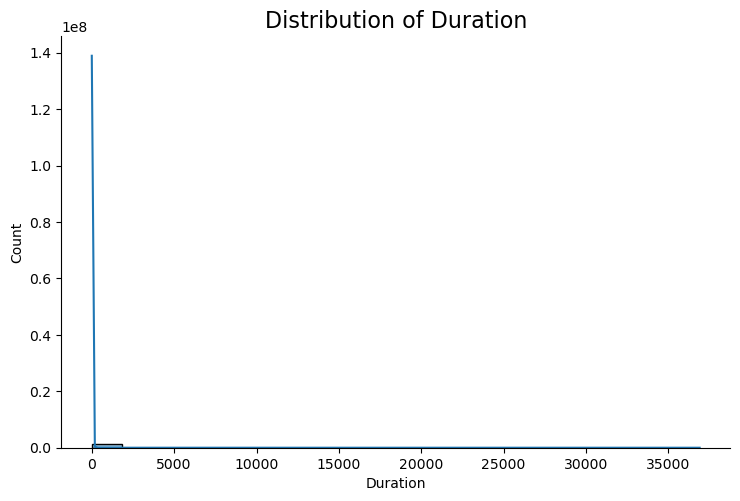

In [35]:
# loop through each numeric column in the DataFrame
for column in df.select_dtypes(include='number').columns:
    # create a histogram with KDE (Kernel Density Estimate) for the current column
    sns.displot(data=df,
                x=column,
                kind='hist',
                bins=20,
                kde=True,
                height=5,
                aspect=1.5)
    # set the title for the plot
    plt.title(f'Distribution of {column}', fontsize=16)
    # display the plot
    plt.show()

### Categorical Variables: Bar Charts
* The histograms for ServerPort and ClientPort reveal distinct distribution patterns. ServerPort shows a heavy concentration of values around a single dominant port, suggesting a specific or default port is frequently used, with much lower counts across other ports. Conversely, ClientPort displays a more distributed pattern, with no single dominant value and a broader range of ports in use, albeit with some areas showing higher concentrations. This likely reflects the dynamic allocation of client ports compared to the more stable, predictable assignment of server ports.

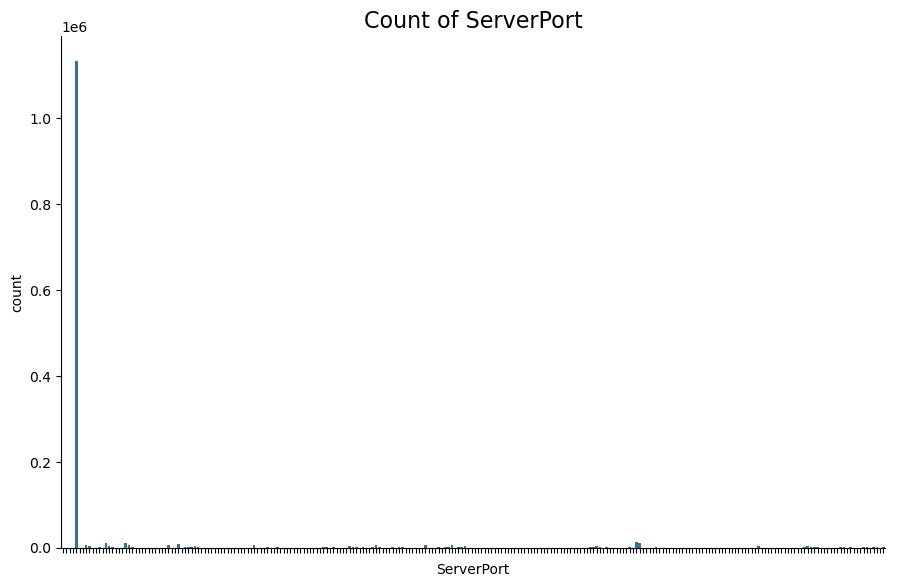

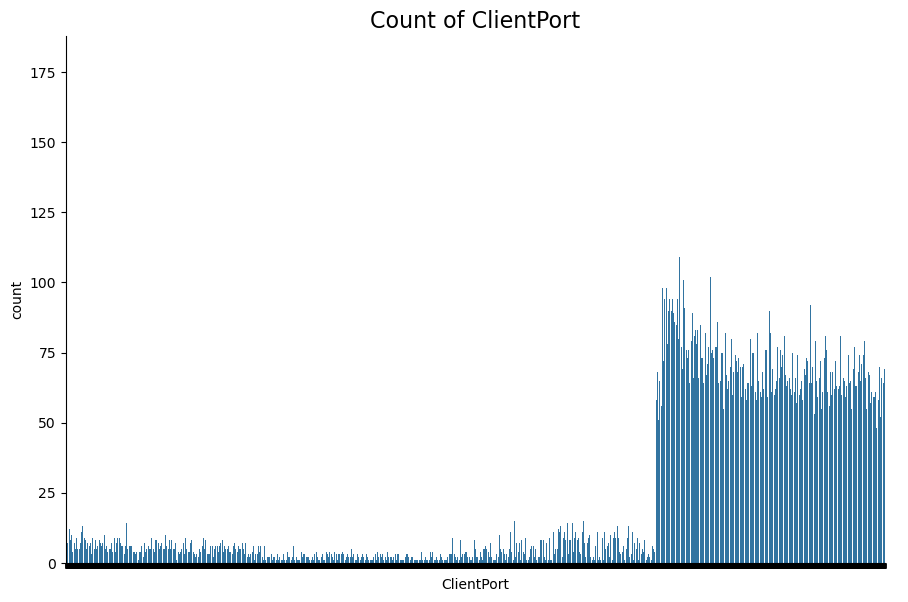

In [36]:
# loop through each non-numeric column in the DataFrame
for column in df.select_dtypes(exclude='number').columns:
    # if the column has 20 or fewer unique values, plot with full x-axis labels
    if df[column].nunique() <= 20:
        sns.catplot(data=df,
                    x=column,
                    kind='count',
                    height=6,
                    aspect=1.5)
        # rotate xticks
        plt.xticks(rotation=90)
        # set the title for the plot
        plt.title(f'Count of {column}', fontsize=16)
        # display the plot
        plt.show()
    # if the column has more than 20 unique values, plot without x-axis labels
    else:
        sns.catplot(data=df,
                    x=column,
                    kind='count',
                    height=6,
                    aspect=1.5)
        # set xticklabels
        plt.gca().set_xticklabels([])
        # set the title for the plot
        plt.title(f'Count of {column}', fontsize=16)
        # display the plot
        plt.show()

## Visualize the Combinations and Conditional Distributions w/ Categorical-to-Categorical Relationships or Combinations

### Categorical-to-Categorical Dodged Bar Charts
* The bar plot shows the count of the top 10 ServerPorts across the top 10 ClientPorts, indicating that certain server ports, like 443, are consistently accessed across various client ports, dominating the distribution. Most of the server ports have similar, high counts across the client ports, suggesting a frequent and uniform access pattern. There is a clear distinction in the count levels among different server ports, with a few outliers having much lower access counts. This pattern highlights the common use of particular server ports in network communication, with 443 (typically used for HTTPS) being the most prevalent.

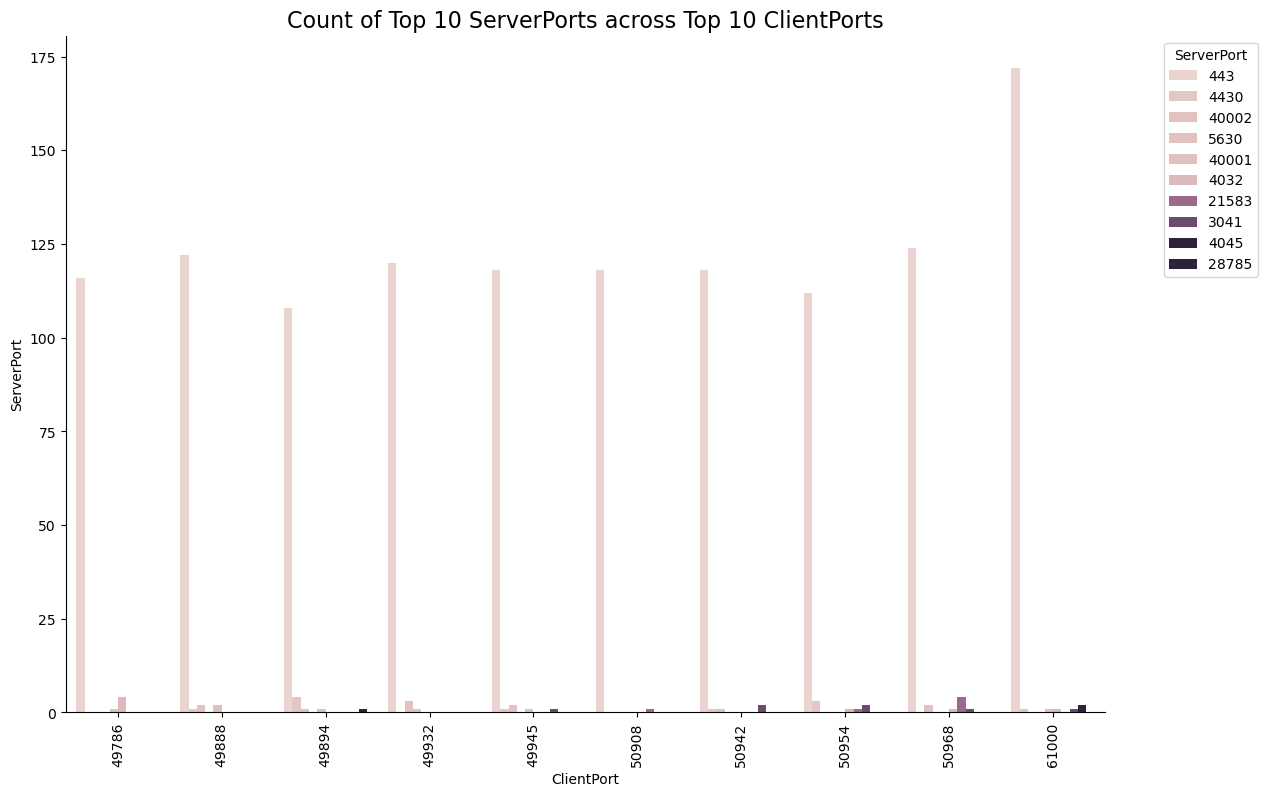

In [37]:
# identify categorical variables in the DataFrame
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# set the number of top unique values to consider for each categorical variable
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to its top N values and process each accordingly
for var in categorical_vars:
    # keep only the top N most frequent values for the current categorical variable
    filtered_dfs[var] = df[df[var].isin(df[var].\
                                        value_counts().\
                                        nlargest(top_n_values).\
                                        index)].\
                                        copy()
    # attempt to convert the variable to numeric if possible and set it as an ordered categorical
    try:
        filtered_dfs[var][var] = pd.to_numeric(filtered_dfs[var][var], errors='raise') 
        ordered_var = filtered_dfs[var][var].\
                      value_counts().\
                      index
        filtered_dfs[var][var] = pd.Categorical(filtered_dfs[var][var], 
                                                categories=ordered_var, 
                                                ordered=True)
    # if conversion fails, skip and keep as categorical
    except ValueError:
        pass 

# iterate over pairs of categorical variables to generate comparative count plots
for i, cat_var_1 in enumerate(categorical_vars):
    for j, cat_var_2 in enumerate(categorical_vars):
        # only plot each unique pair once (skip redundant pairs)
        if i < j:
            # merge the filtered DataFrames for the two categorical variables
            filtered_df = filtered_dfs[cat_var_1].merge(filtered_dfs[cat_var_2], how='inner')
            # plot count distribution of cat_var_2, colored by cat_var_1 categories
            g = sns.catplot(data=filtered_df,
                            x=cat_var_2, 
                            hue=cat_var_1,
                            kind='count',
                            height=7.5, 
                            aspect=1.5,
                            legend=False) 
            # set plot title and axis labels
            plt.title(f'Count of Top 10 {cat_var_1}s across Top 10 {cat_var_2}s', fontsize=16)
            plt.ylabel(cat_var_1)
            plt.xlabel(cat_var_2)
            plt.xticks(rotation=90)
            # place the legend outside the plot for readability
            plt.legend(title=cat_var_1, 
                       bbox_to_anchor=(1.05, 1), 
                       loc='upper left', 
                       labels=filtered_df[cat_var_1].\
                       unique())
            # display the plot
            plt.show()

### Categorical-to-Categorical Heatmaps
* The heatmap displays the interaction between the top 10 ServerPorts and the top 10 ClientPorts, highlighting the frequency of connections. ServerPort 443 shows consistently high interaction counts across multiple ClientPorts, as indicated by the warmer colors, suggesting it is heavily utilized. In contrast, other server ports show minimal interactions, with most cells containing zeros, indicating sparse usage across these client ports. This pattern reinforces that server port 443 (commonly associated with HTTPS) is the primary port used, while other ports are accessed only occasionally.

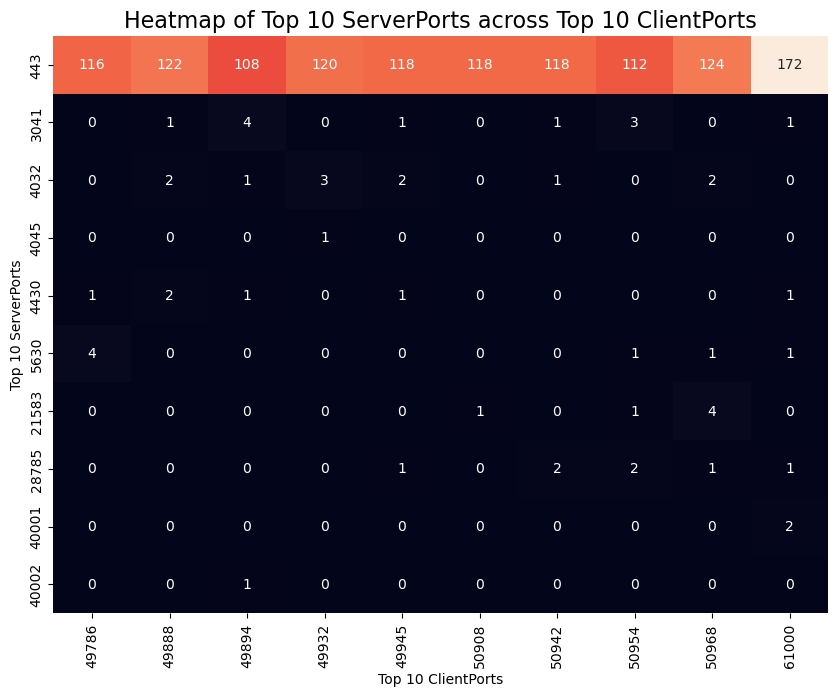

In [38]:
# identify categorical variables in the DataFrame
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# set the number of top unique values to consider for each categorical variable
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to its top N values and process each accordingly
for var in categorical_vars:
    # keep only the top N most frequent values for the current categorical variable
    filtered_dfs[var] = df[df[var].isin(df[var].\
                                        value_counts().\
                                        nlargest(top_n_values).\
                                        index)].\
                                        copy()
    # attempt to convert the variable to numeric if possible and set it as an ordered categorical
    try:
        filtered_dfs[var][var] = pd.to_numeric(filtered_dfs[var][var], errors='raise')
        ordered_var = filtered_dfs[var][var].value_counts().index
        filtered_dfs[var][var] = pd.Categorical(filtered_dfs[var][var], 
                                                categories=ordered_var, 
                                                ordered=True)
    # if conversion fails, skip and keep as categorical
    except ValueError:
        pass

# iterate over pairs of categorical variables to generate comparative heatmaps
for i, cat_var_1 in enumerate(categorical_vars):
    for j, cat_var_2 in enumerate(categorical_vars):
        # only plot each unique pair once (skip redundant pairs)
        if i < j:
            # merge the filtered DataFrames for the two categorical variables
            filtered_df = filtered_dfs[cat_var_1].merge(filtered_dfs[cat_var_2], how='inner')
            # create a pivot table counting occurrences of each pair of categories
            pivot_table = filtered_df.pivot_table(index=cat_var_1, 
                                                  columns=cat_var_2, 
                                                  aggfunc='size', 
                                                  fill_value=0)
            # plot the heatmap
            plt.figure(figsize=(10, 7.5))
            sns.heatmap(pivot_table, 
                        annot=True, 
                        fmt='g', 
                        cbar=False)
            # set plot title and axis labels
            plt.title(f'Heatmap of Top 10 {cat_var_1}s across Top 10 {cat_var_2}s', fontsize=16)
            plt.ylabel(f'Top 10 {cat_var_1}s')
            plt.xlabel(f'Top 10 {cat_var_2}s')
            plt.xticks(rotation=90)
            # display the plot
            plt.show()

## Visualize the Categorical-to-Continuous Relationships or Conditional Distributions

### Categorical-to-Continuous Box Plots, Violin Plots, and Point Plots
* The visualizations provide a detailed look at the log-transformed distributions and mean values of UpBytes, DownBytes, TcpRtt, and Duration across the top 10 ServerPorts and ClientPorts. The box plots and violin plots reveal that ServerPort 443 exhibits a wide range with higher outliers, indicating greater variability in traffic volume and response times, whereas other ports like 40001 and 40002 display more compact distributions with fewer outliers, suggesting more stable usage patterns. ClientPorts show relatively consistent distributions with moderate variability and outliers across metrics. The line plots of mean values highlight that certain ServerPorts, such as 40001 and 21583, tend to have higher average UpBytes and DownBytes, while port 443 shows lower values across metrics. In contrast, ClientPorts exhibit less pronounced differences in mean values. Together, these transformations and visualizations provide a normalized view of the data, uncovering subtle distinctions in port behavior and traffic characteristics, with ServerPorts demonstrating more variability in average usage compared to ClientPorts.

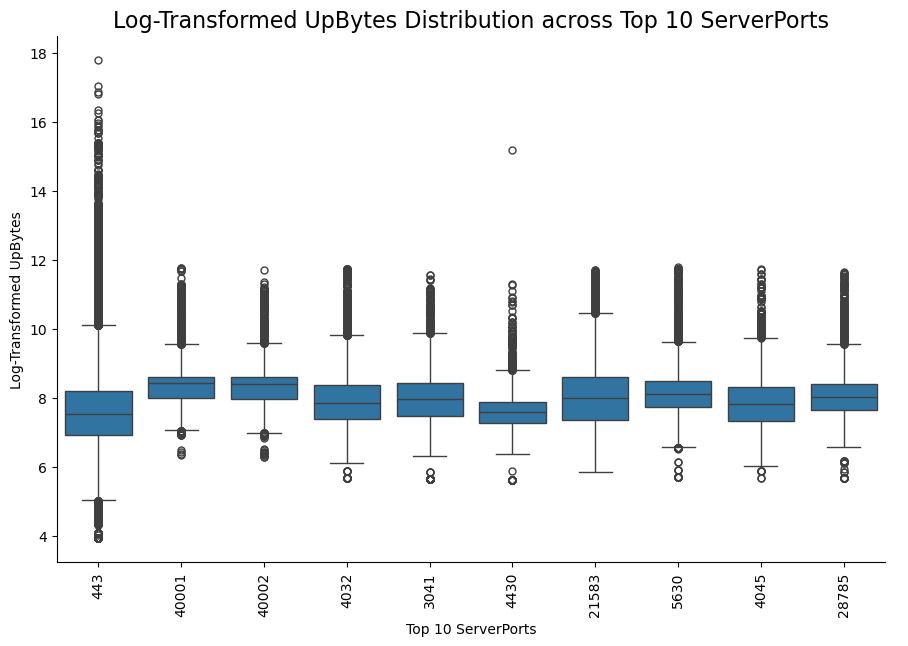

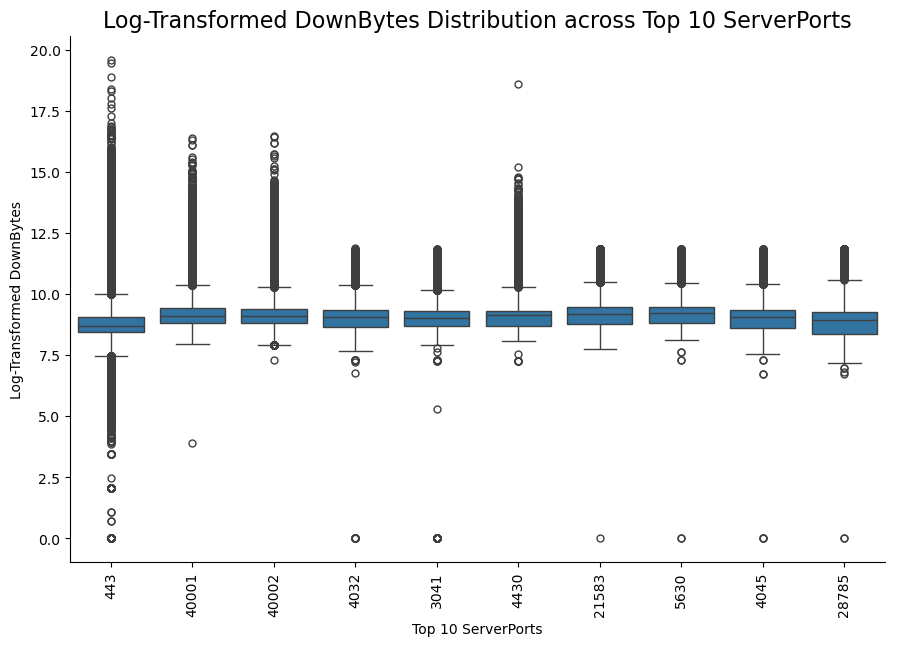

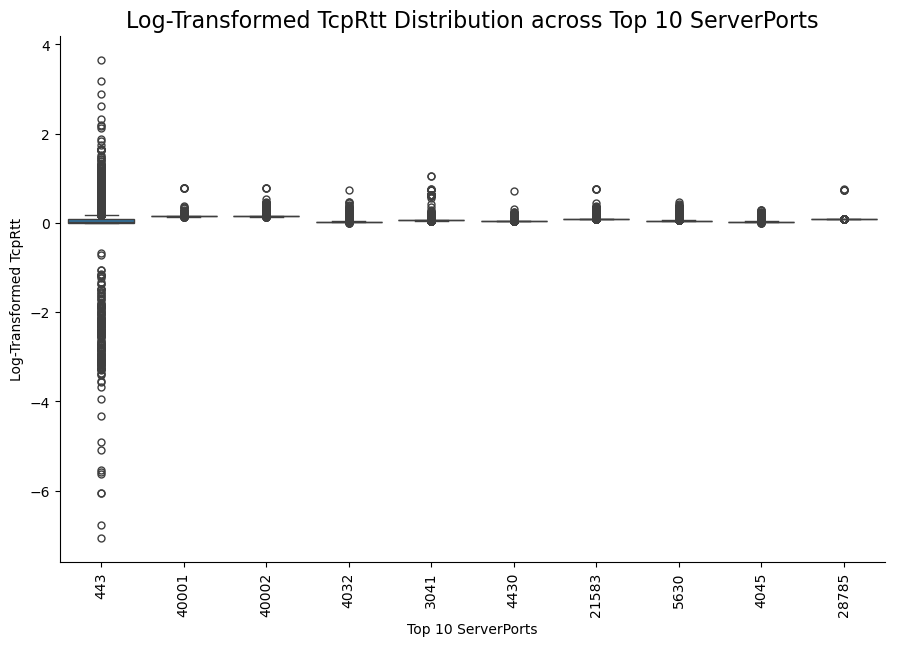

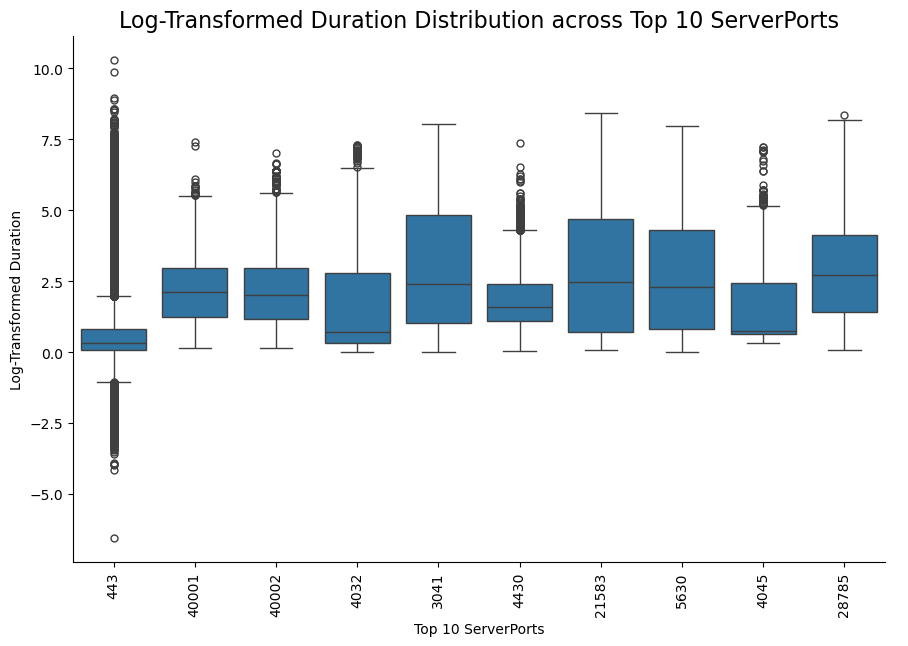

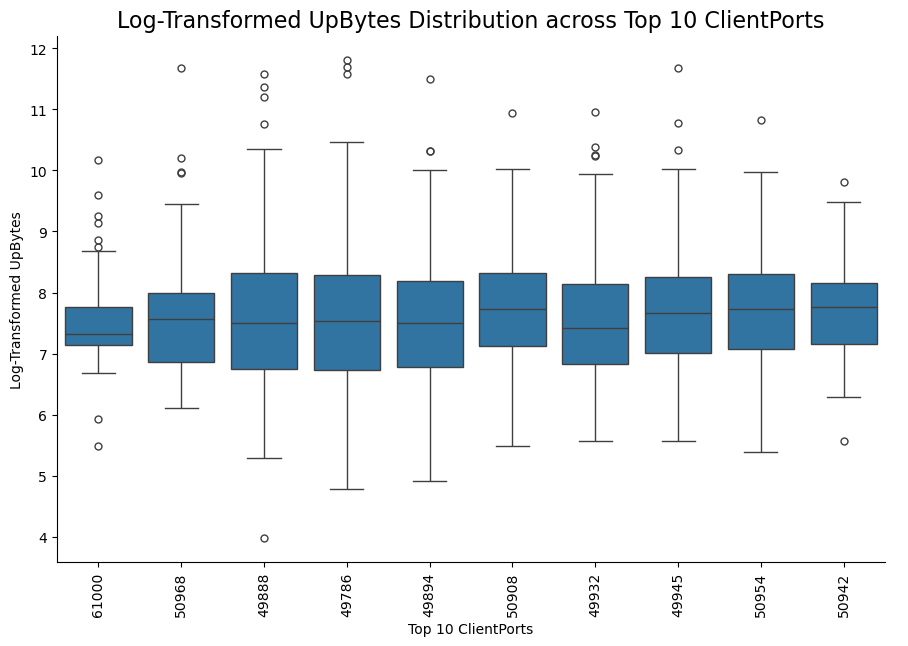

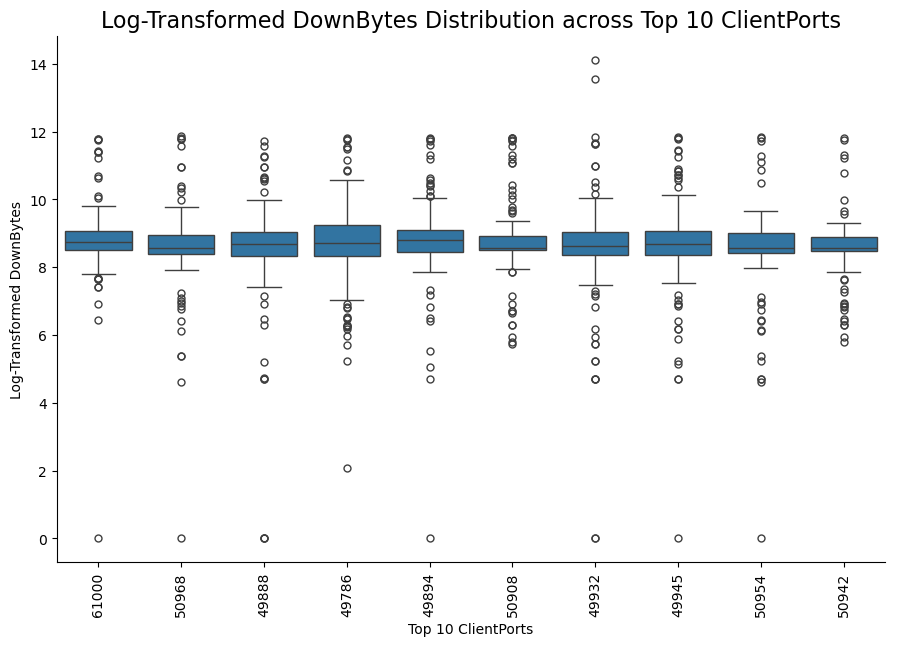

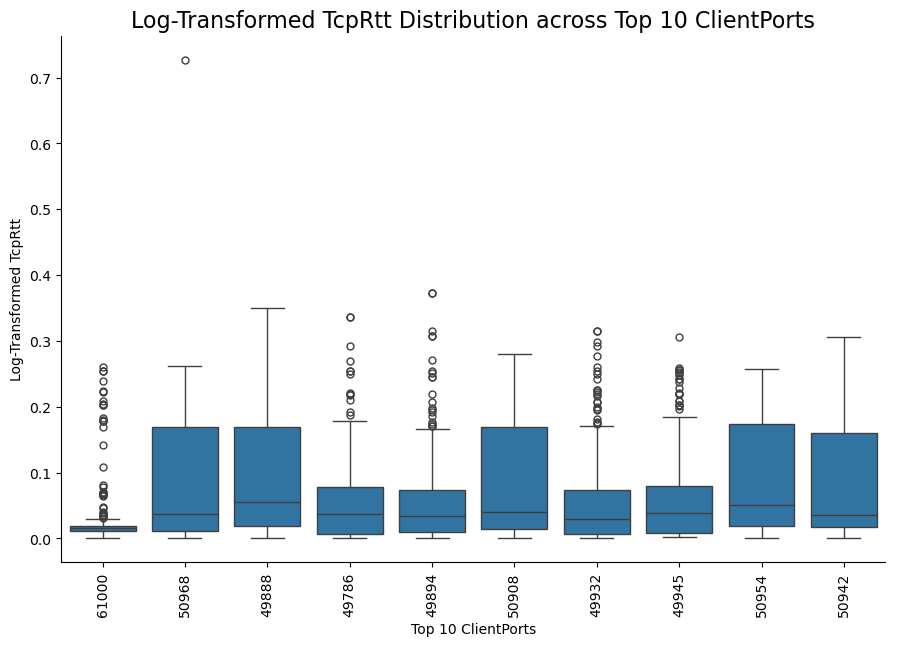

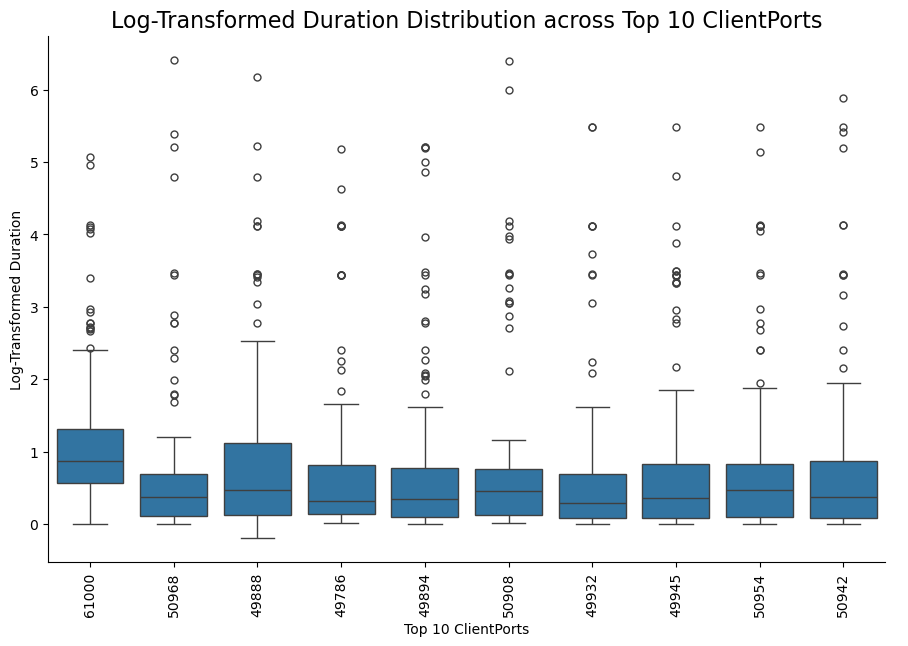

In [39]:
# select categorical variables, excluding the target variable 'is_tunnel_traffic'
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']

# select continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values to include for each categorical variable
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    filtered_dfs[var] = df[df[var].isin(df[var].\
                                        value_counts().\
                                        nlargest(top_n_values).\
                                        index)].\
                                        copy()
    # attempt to convert the variable to numeric if possible and set it as an ordered categorical
    try:
        filtered_dfs[var][var] = pd.to_numeric(filtered_dfs[var][var], errors='raise')
        ordered_var = filtered_dfs[var][var].value_counts().index
        filtered_dfs[var][var] = pd.Categorical(filtered_dfs[var][var], 
                                                categories=ordered_var, 
                                                ordered=True)
    # if conversion fails, keep the variable as it is
    except ValueError:
        pass

# iterate over each pair of categorical and continuous variables
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame for the current categorical variable
        filtered_df = filtered_dfs.get(cat_var)
        # if there is a filtered DataFrame, apply log transformation and generate a box plot
        if filtered_df is not None:
            # apply log transformation to the continuous variable to handle skewness
            filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x)
            # create the box plot
            sns.catplot(data=filtered_df, 
                        x=cat_var, 
                        y=cont_var, 
                        kind='box', 
                        height=6, 
                        aspect=1.5)
            # set plot title and axis labels
            plt.title(f'Log-Transformed {cont_var} Distribution across Top 10 {cat_var}s', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Log-Transformed {cont_var}')
            plt.xticks(rotation=90)
            # display the plot
            plt.show()

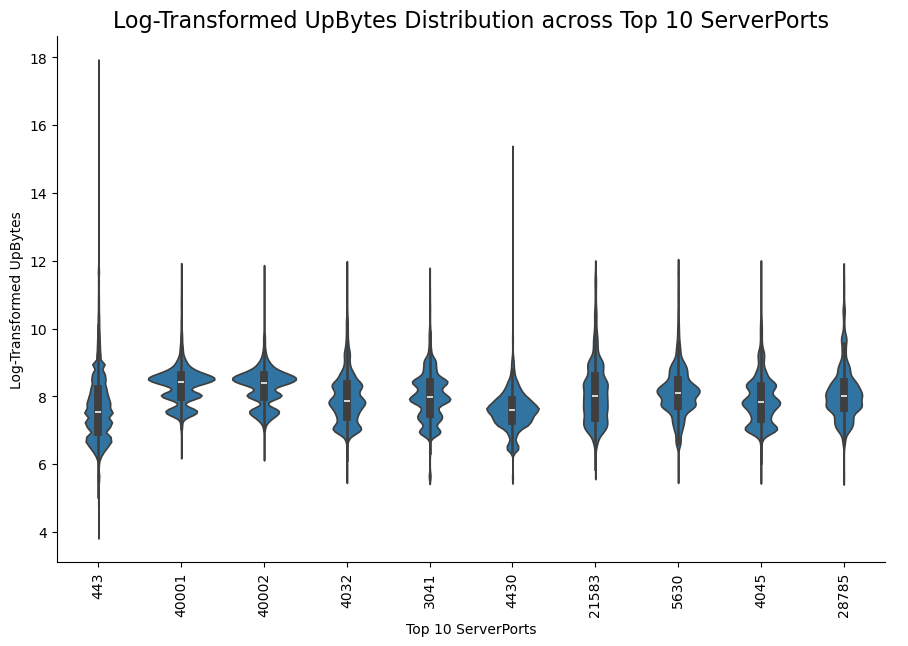

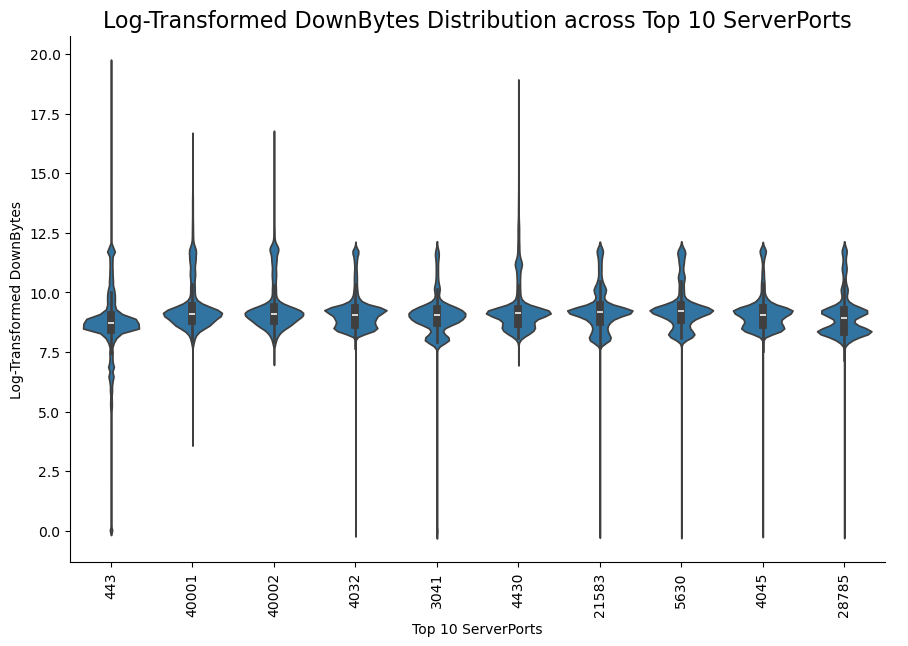

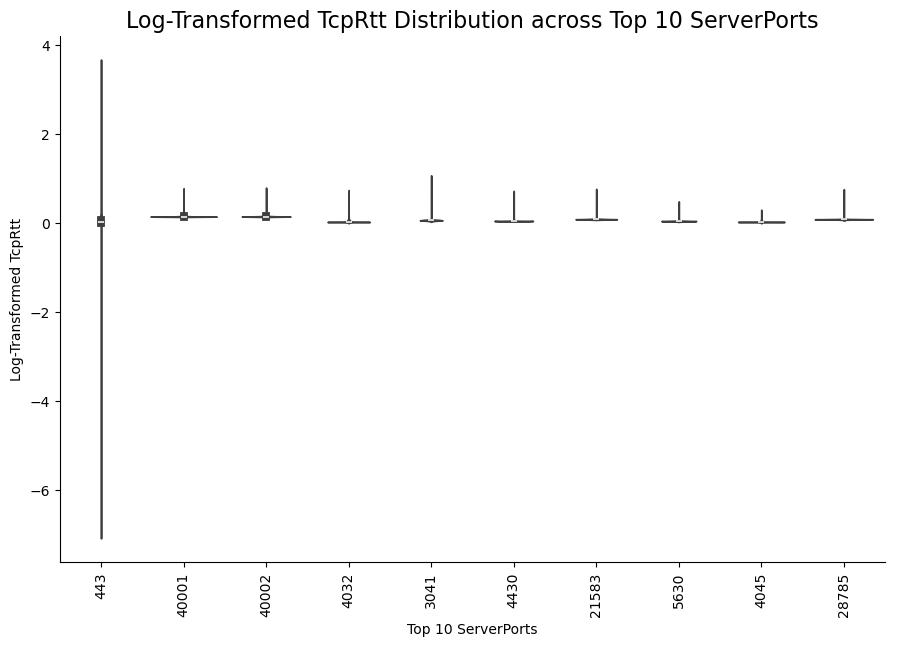

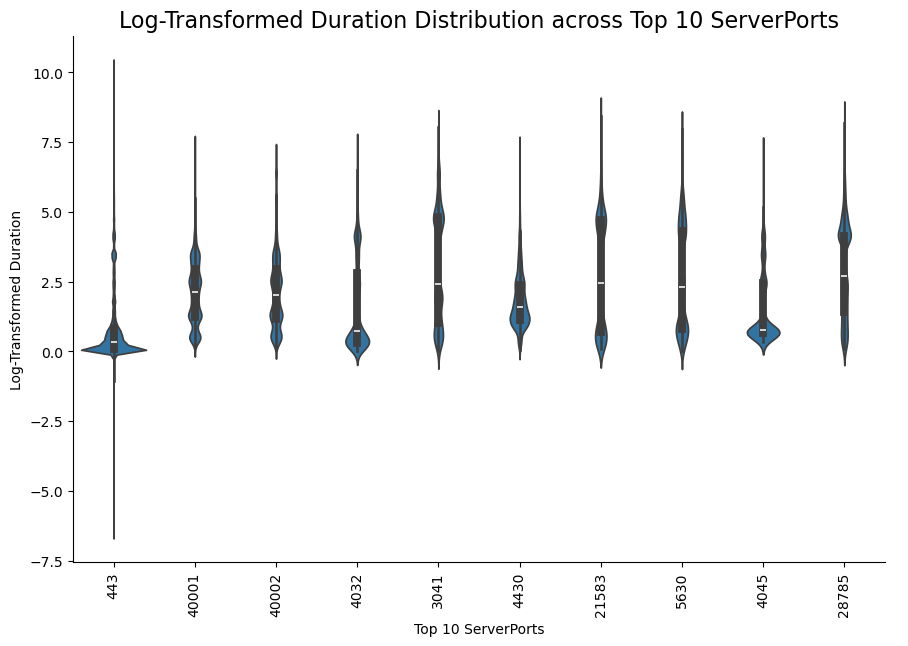

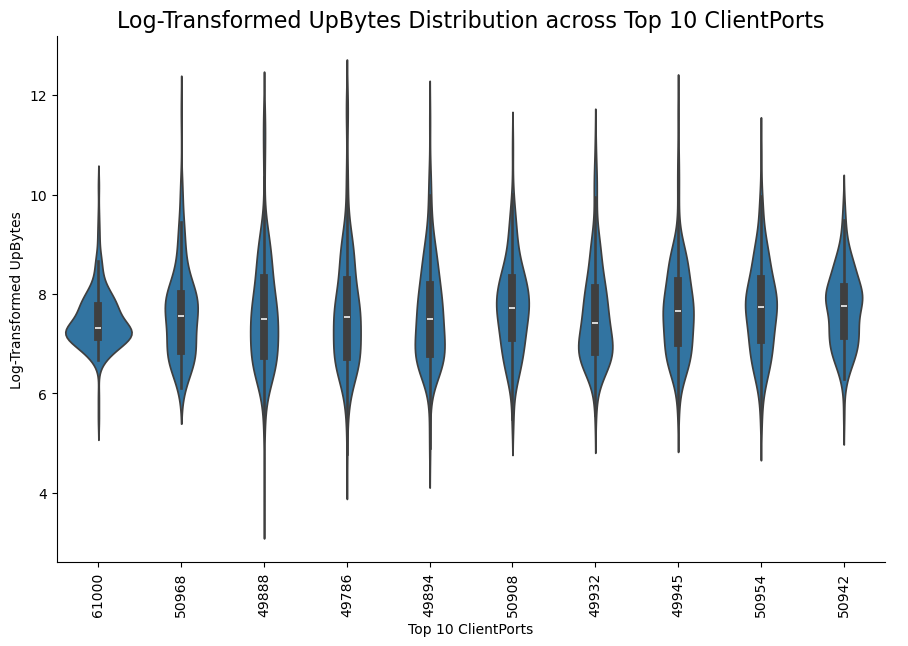

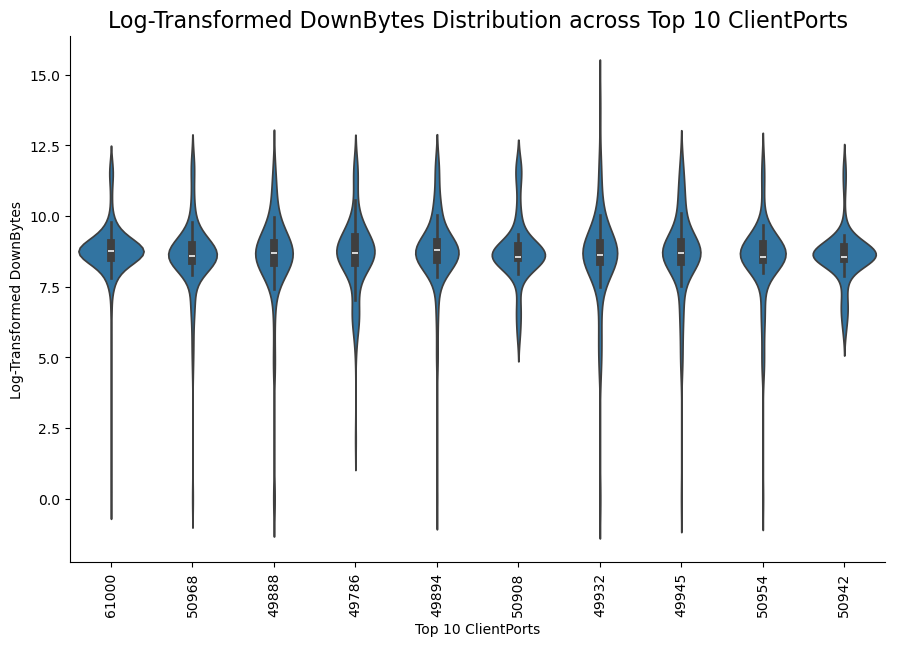

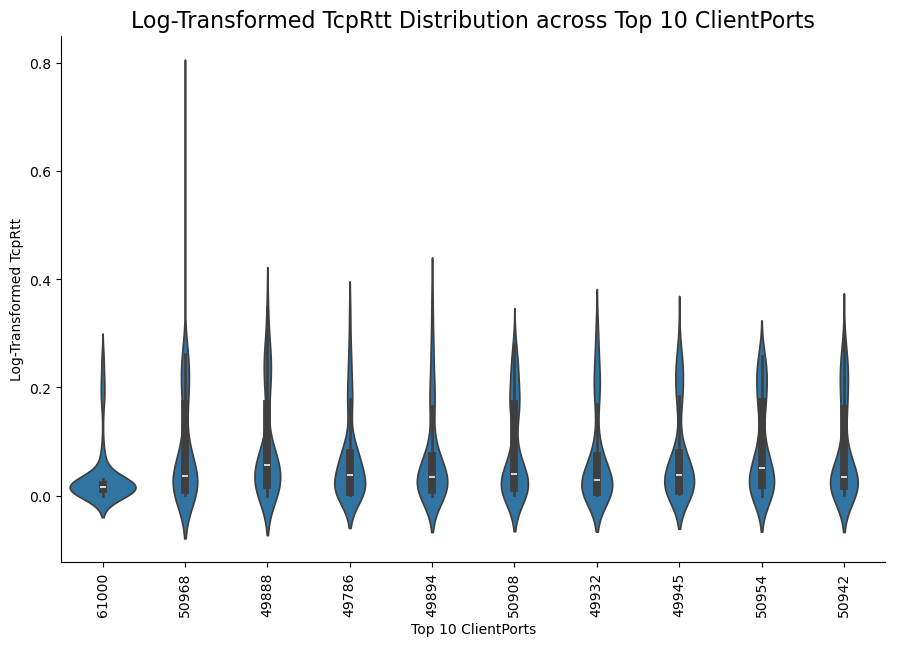

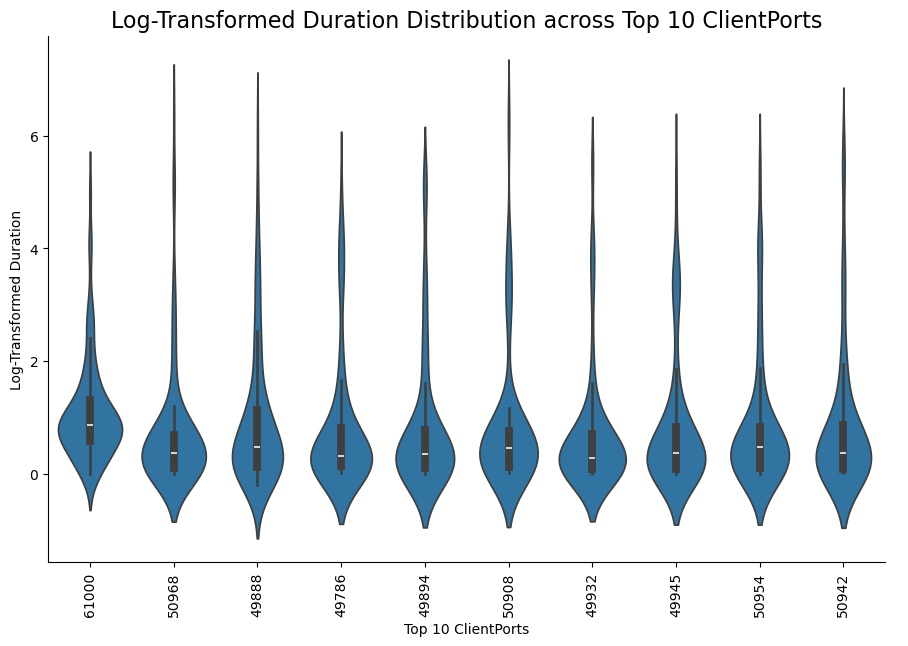

In [40]:
# select categorical variables, excluding the target variable 'is_tunnel_traffic'
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']

# select continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values to include for each categorical variable
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    filtered_dfs[var] = df[df[var].isin(df[var].\
                                        value_counts().\
                                        nlargest(top_n_values).\
                                        index)].\
                                        copy()
    # attempt to convert the variable to numeric if possible and set it as an ordered categorical
    try:
        filtered_dfs[var][var] = pd.to_numeric(filtered_dfs[var][var], errors='raise')
        ordered_var = filtered_dfs[var][var].\
                      value_counts().\
                      index
        filtered_dfs[var][var] = pd.Categorical(filtered_dfs[var][var], 
                                                categories=ordered_var, 
                                                ordered=True)
    # if conversion fails, keep the variable as it is
    except ValueError:
        pass

# iterate over each pair of categorical and continuous variables
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame for the current categorical variable
        filtered_df = filtered_dfs.get(cat_var)
        # if there is a filtered DataFrame, apply log transformation and generate a violin plot
        if filtered_df is not None:
            # apply log transformation to the continuous variable to handle skewness
            filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x)
            # create the violin plot
            sns.catplot(data=filtered_df, 
                        x=cat_var, 
                        y=cont_var, 
                        kind='violin', 
                        height=6, 
                        aspect=1.5)
            # set plot title and axis labels
            plt.title(f'Log-Transformed {cont_var} Distribution across Top 10 {cat_var}s', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Log-Transformed {cont_var}')
            plt.xticks(rotation=90)
            # display the plot
            plt.show()

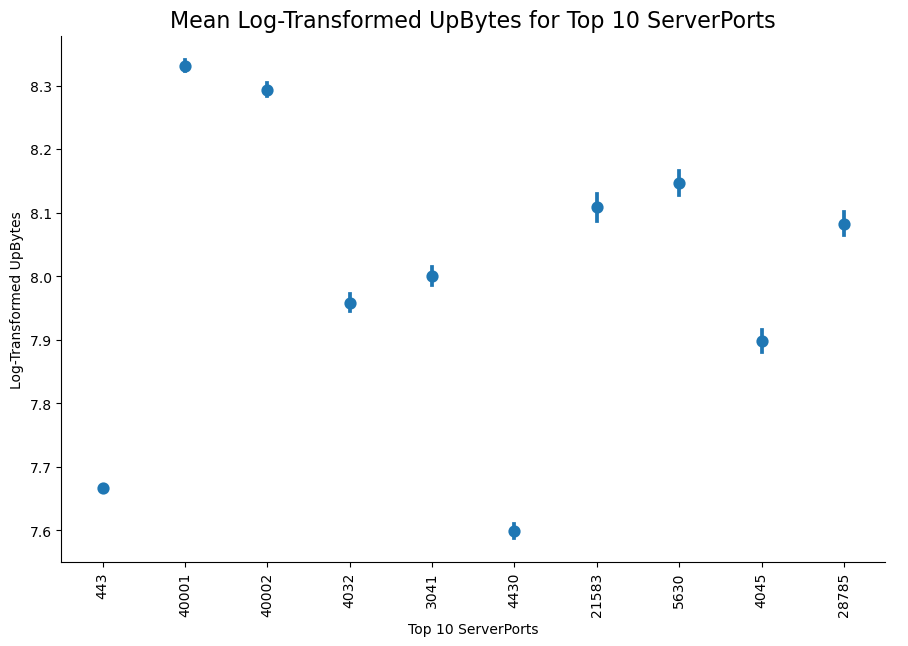

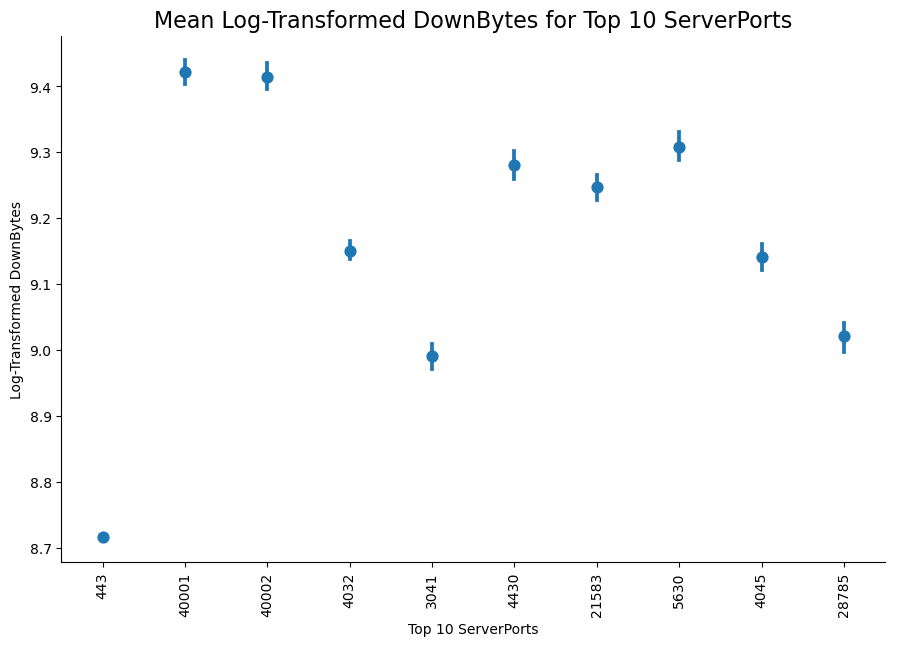

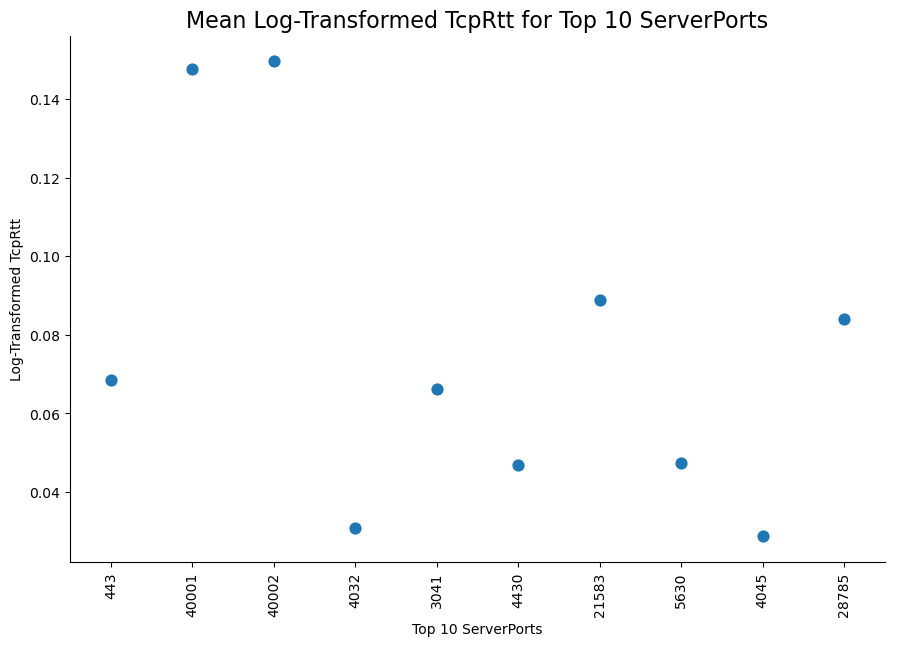

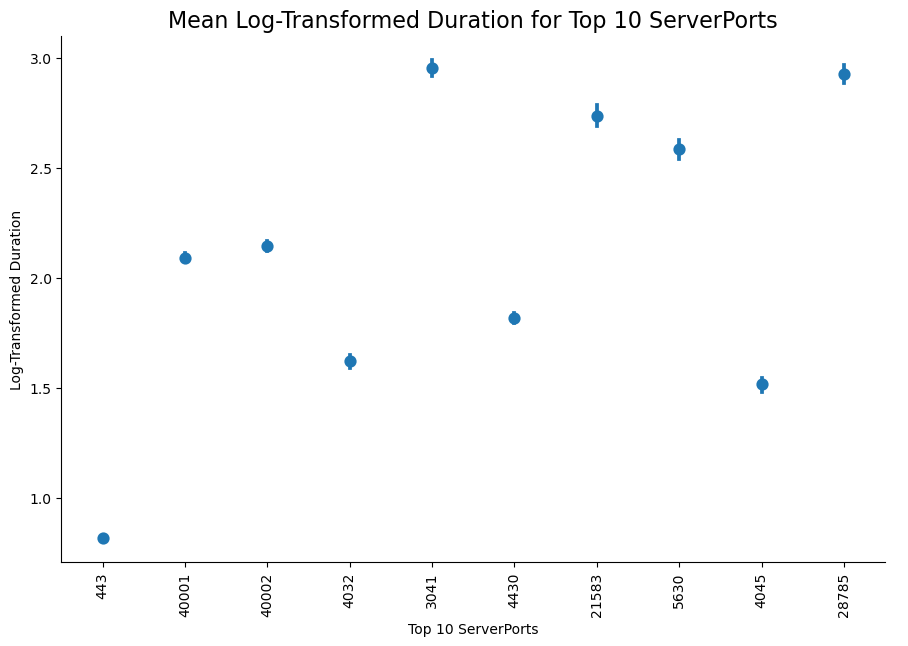

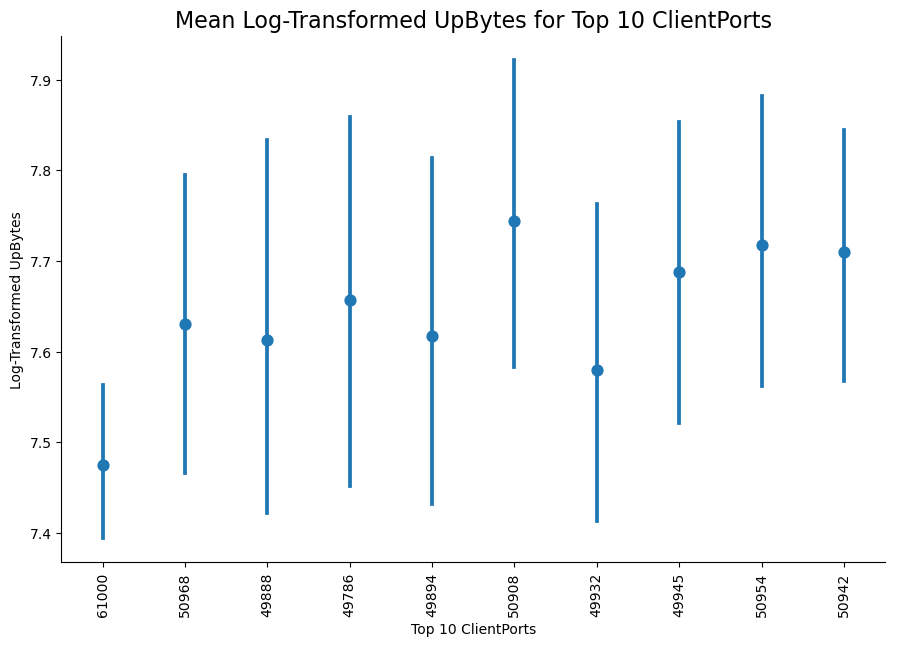

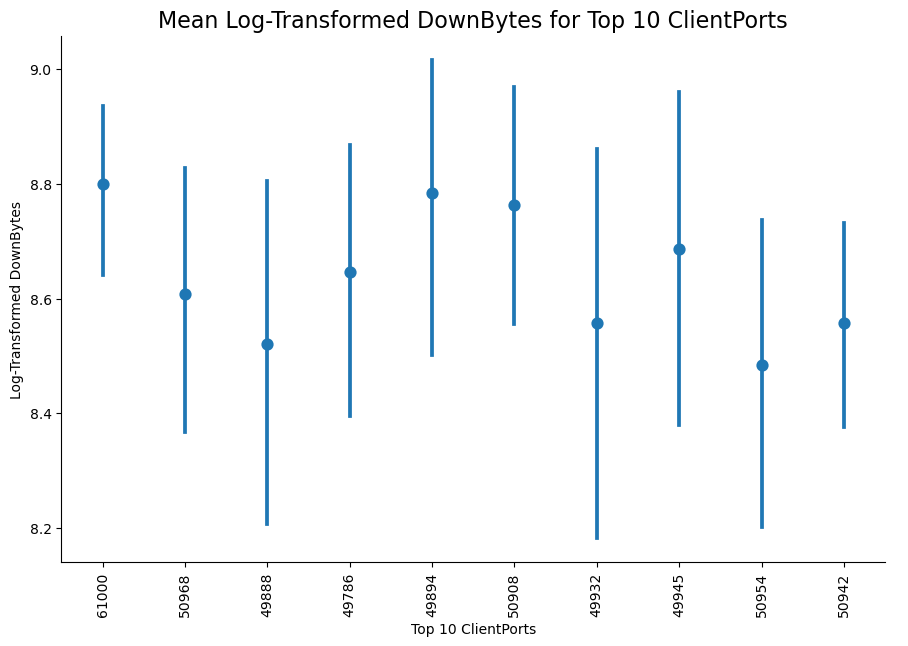

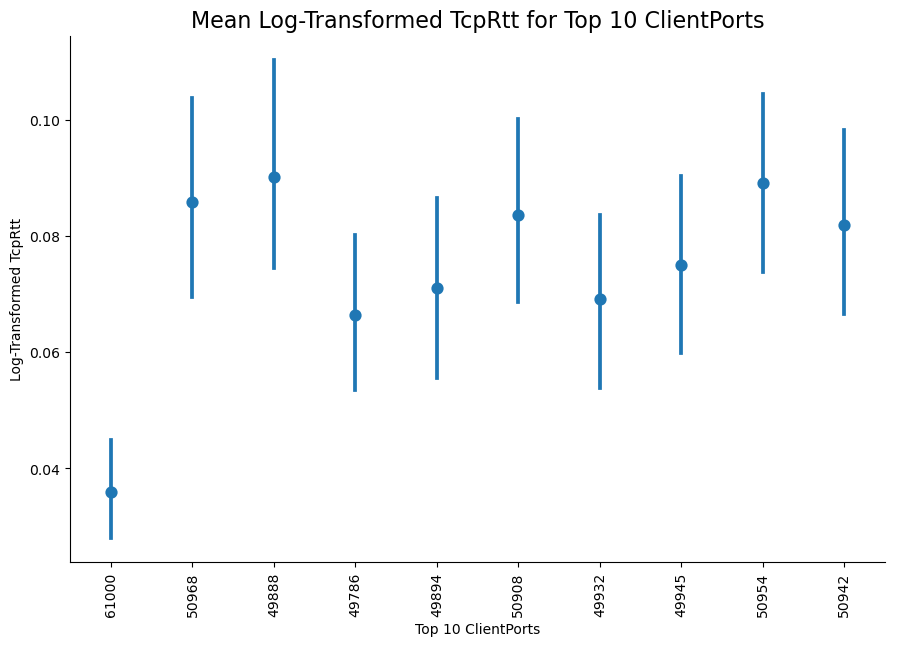

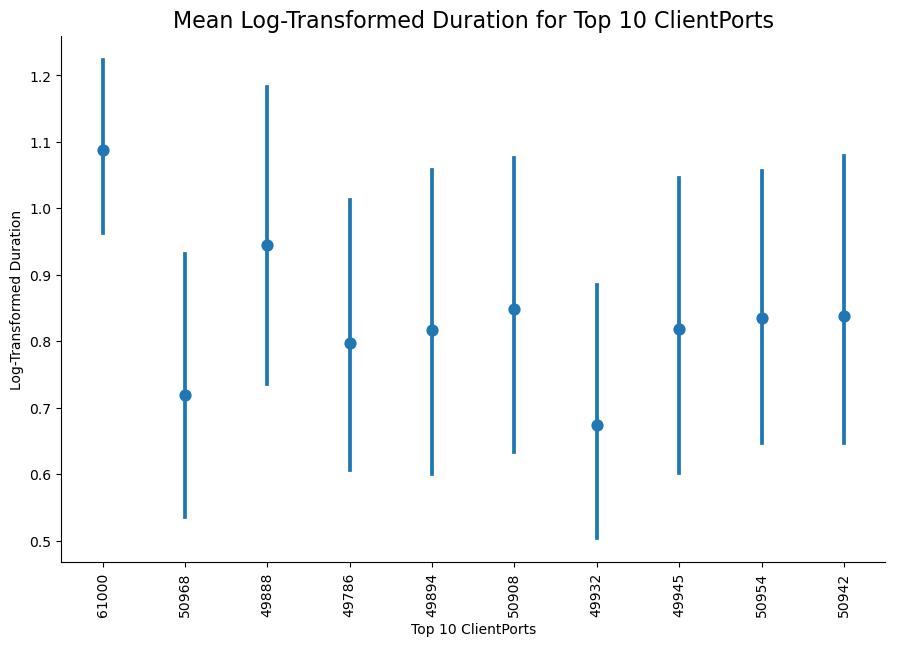

In [41]:
# select categorical variables, excluding the target variable 'is_tunnel_traffic'
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']

# select continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values to include for each categorical variable
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    filtered_dfs[var] = df[df[var].isin(df[var].\
                                        value_counts().\
                                        nlargest(top_n_values).\
                                        index)].\
                                        copy()
    # attempt to convert the variable to numeric if possible and set it as an ordered categorical
    try:
        filtered_dfs[var][var] = pd.to_numeric(filtered_dfs[var][var], errors='raise')
        ordered_var = filtered_dfs[var][var].value_counts().index
        filtered_dfs[var][var] = pd.Categorical(filtered_dfs[var][var], 
                                                categories=ordered_var, 
                                                ordered=True)
    # if conversion fails, keep the variable as it is
    except ValueError:
        pass

# iterate over each pair of categorical and continuous variables
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame for the current categorical variable
        filtered_df = filtered_dfs.get(cat_var) 
        # if there is a filtered DataFrame, apply log transformation and generate a point plot
        if filtered_df is not None:
            # apply log transformation to the continuous variable to handle skewness
            filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x)    
            # create the point plot to display the mean values with error bars
            sns.catplot(data=filtered_df, 
                        x=cat_var, 
                        y=cont_var, 
                        kind='point', 
                        linestyles='', 
                        height=6, 
                        aspect=1.5)      
            # set plot title and axis labels
            plt.title(f'Mean Log-Transformed {cont_var} for Top 10 {cat_var}s', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Log-Transformed {cont_var}')
            plt.xticks(rotation=90)   
            # display the plot
            plt.show()

## Visualize the Continuous-to-Continuous Relationships or Conditional Distributions

### Pairplot and Correlation Plot
* The pairwise scatter plot matrix shows the relationships between UpBytes, DownBytes, TcpRtt, and Duration, highlighting the skewed distributions and clustering of low values across variables, with a few larger outliers. Most pairs exhibit no clear linear relationship, except for a moderate positive association between UpBytes and DownBytes. This relationship is confirmed in the correlation heatmap, where UpBytes and DownBytes have a moderate positive correlation of 0.55. The other variables show negligible correlations, suggesting minimal linear relationships among them. This analysis indicates that UpBytes and DownBytes may share some underlying connection, while the other variables behave independently in this dataset.

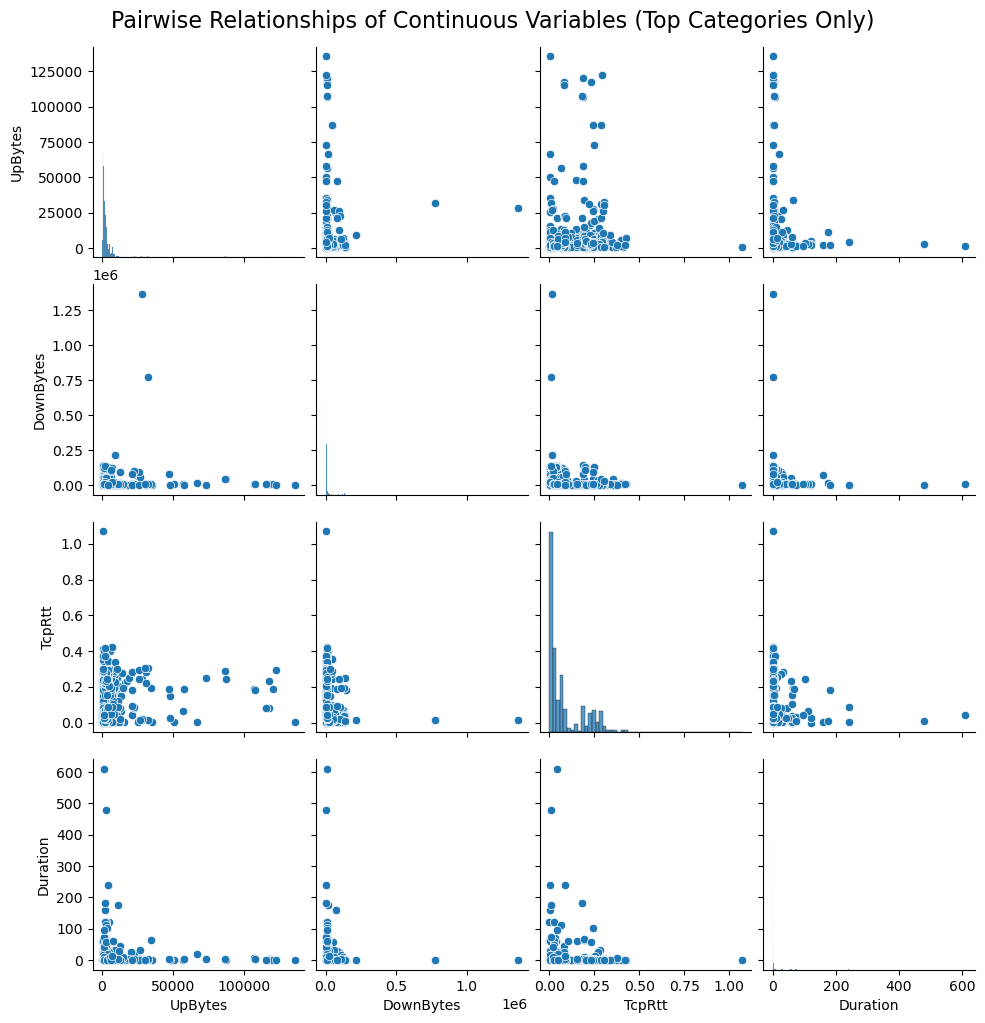

In [42]:
# define categorical variables, excluding the target variable 'is_tunnel_traffic'
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']

# define continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values to include for each categorical variable
top_n_values = 10

# create a copy of the DataFrame to filter by top N values of each categorical variable
filtered_df = df.copy()

# filter rows to include only the top N values for each categorical variable
for cat_var in categorical_vars:
    # get the top N values for the current categorical variable
    top_values = filtered_df[cat_var].value_counts().\
                                      nlargest(top_n_values).\
                                      index
    # keep only rows where the categorical variable is in the top N values
    filtered_df = filtered_df[filtered_df[cat_var].isin(top_values)]

# generate a pairplot for the filtered continuous variables, showing pairwise relationships
sns.pairplot(filtered_df[continuous_vars], height=2.5)

# add a title to the plot for clarity
plt.suptitle("Pairwise Relationships of Continuous Variables (Top Categories Only)", y=1.02, fontsize=16)

# display the plot
plt.show()

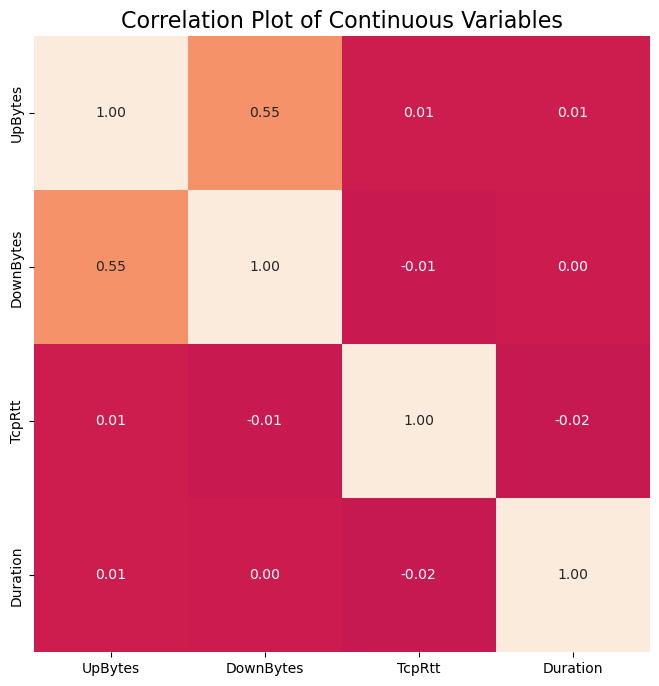

In [43]:
# define continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set figure size for the correlation plot
plt.figure(figsize=(10, 8))

# calculate the correlation matrix for continuous variables
corr_matrix = df[continuous_vars].corr()

# plot the heatmap of the correlation matrix
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cbar=False, 
            vmin=-1, 
            vmax=1, 
            square=True)

# set title and display the heatmap
plt.title("Correlation Plot of Continuous Variables", fontsize=16)

# display the plot
plt.show()

## Visualize the Relationship Across Groups

### Trend Plots
* The scatter plots highlight the relationship between UpBytes and DownBytes across top server and client ports, showcasing both linear trends and port-specific variations. For server ports, Port 443 demonstrates a clear, positive trend with DownBytes increasing alongside UpBytes, indicating substantial data exchange, particularly compared to smaller exchanges in ports like 40001 and 40002. Similarly, for client ports, data transfer patterns vary, with ports like 50968 and 49888 showing higher DownBytes for similar UpBytes. Overall, these plots illustrate distinct bandwidth utilization patterns, with ServerPort 443 and high-activity client ports engaging in larger-scale data exchanges, potentially suggesting distinct usage or traffic types for these ports.

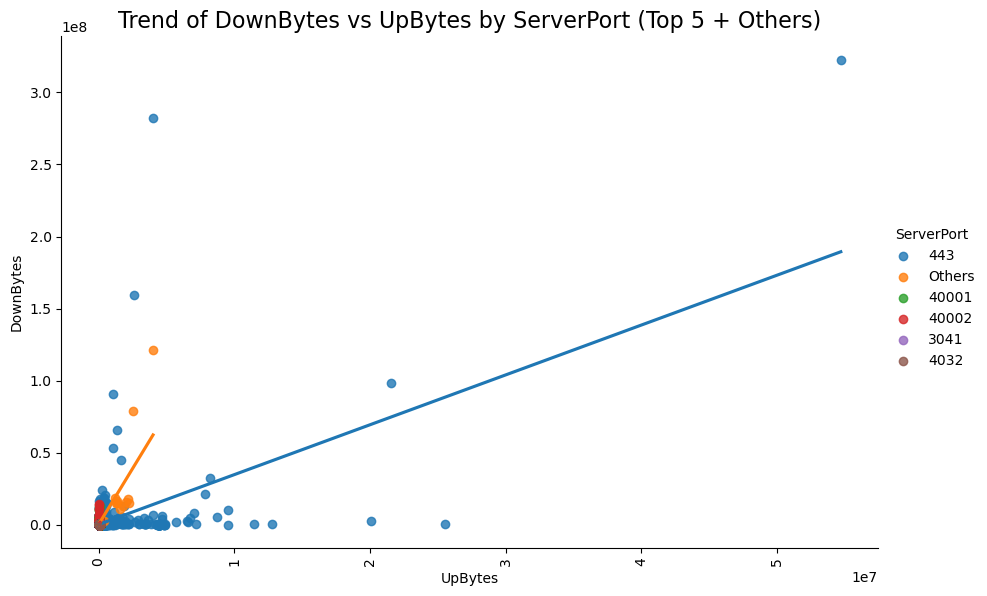

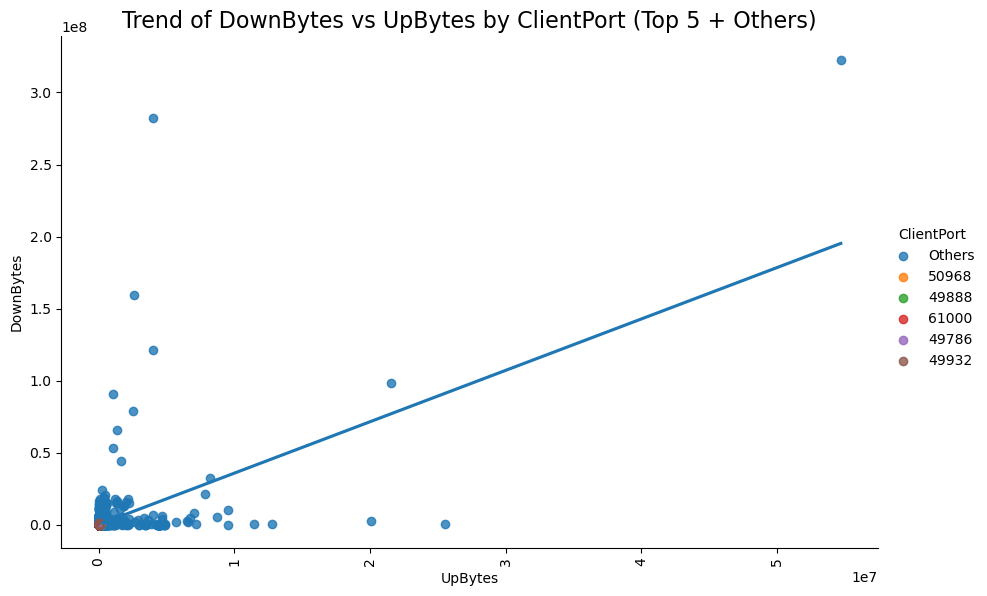

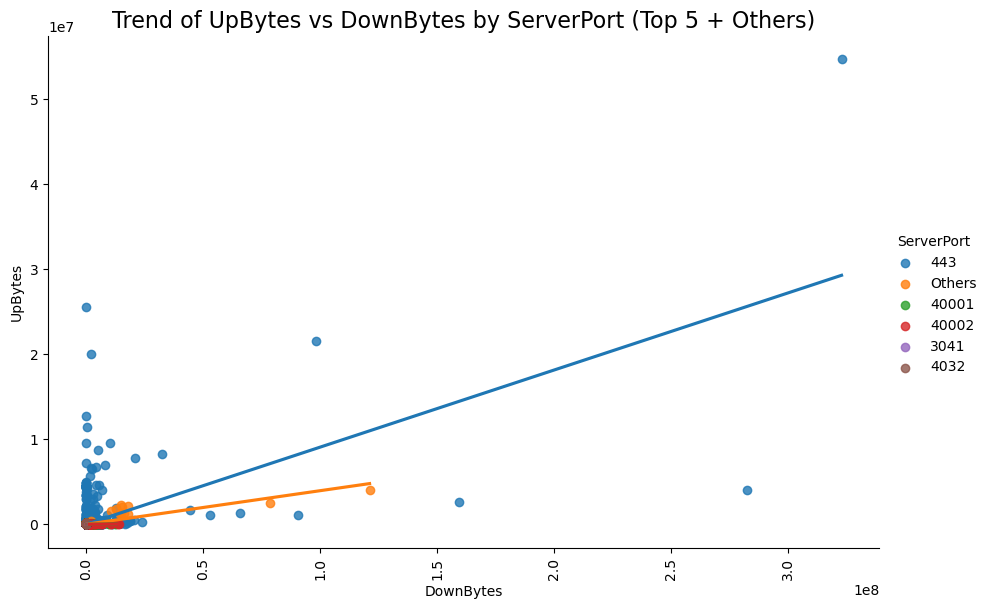

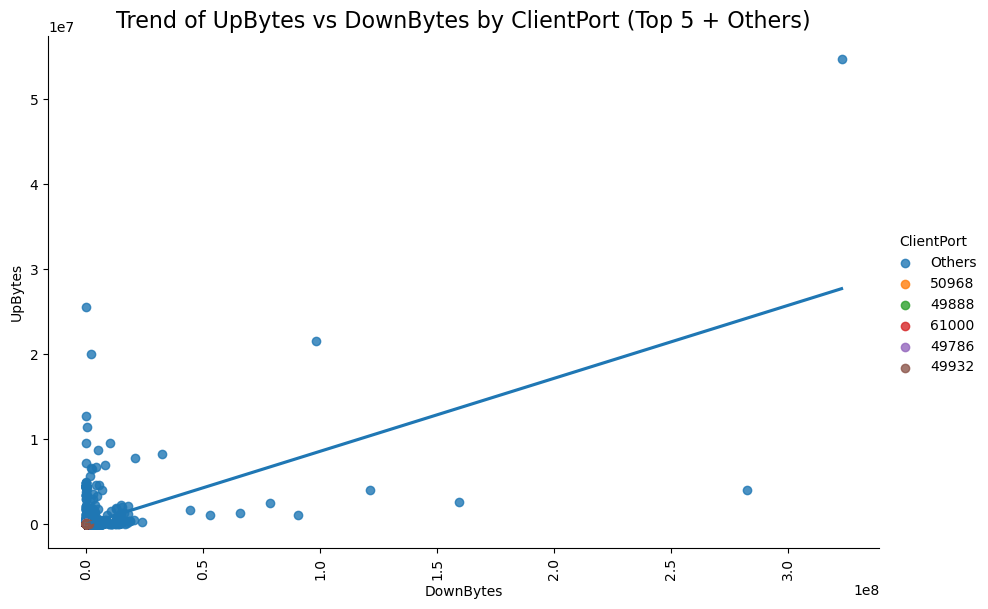

In [44]:
# define categorical variables, excluding the target variable 'is_tunnel_traffic'
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']

# define continuous variables, excluding the target variable 'is_tunnel_traffic'
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values in each categorical variable for readability in plots
top_n_values = 5  

# set the range for intermediate correlation values to focus on pairs with moderate relationships
correlation_threshold = (0.2, 0.8)

# calculate the correlation matrix for continuous variables and use absolute values to capture positive and negative relationships
corr_matrix = df[continuous_vars].corr().abs()  

# identify pairs of continuous variables with correlations within the specified range
pairs_to_plot = [(x_var, y_var) for x_var in continuous_vars for y_var in continuous_vars 
                 if x_var != y_var and correlation_threshold[0] <= corr_matrix.loc[x_var, y_var] <= correlation_threshold[1]]

# iterate over selected pairs of continuous variables with limited hue categories
for x_var, y_var in pairs_to_plot:
    for hue_var in categorical_vars:
        # select the top N values for the hue variable and label the remaining as 'Others' for simplicity
        top_hue_values = df[hue_var].value_counts().\
                                     nlargest(top_n_values).\
                                     index
        filtered_df = df.copy()
        filtered_df[hue_var] = filtered_df[hue_var].apply(lambda x: x if x in top_hue_values else 'Others')
        # plot the continuous-to-continuous relationship with limited categorical hue
        sns.lmplot(data=filtered_df, 
                   x=x_var, 
                   y=y_var, 
                   hue=hue_var, 
                   height=6, 
                   aspect=1.5, 
                   ci=None) 
        # add title and axis labels for clarity
        plt.title(f'Trend of {y_var} vs {x_var} by {hue_var} (Top {top_n_values} + Others)', fontsize=16)
        plt.xlabel(x_var)
        plt.ylabel(y_var)
        plt.xticks(rotation=90)
        # display the plot
        plt.show()

## Summarize the Categorical-to-Continuous Response Relationships or Conditional Distributions

### Categorical-to-Continuous Response Relationship Box Plots, Violin Plots, and Point Plots
* The box plots, violin plots, and point plots collectively reveal that tunnel traffic (is_tunnel_traffic = 1) generally exhibits higher median and mean log-transformed values across UpBytes, DownBytes, TcpRtt, and Duration compared to non-tunnel traffic, especially on key ServerPorts such as 443. Tunnel traffic also shows greater variability and more outliers, suggesting it handles larger data volumes and may incur longer response times and durations. This pattern is consistent across both ServerPorts and ClientPorts, with significant distinctions noted in metrics like Duration and TcpRtt, where tunnel traffic values are notably higher and more dispersed. The lack of overlap in mean values for tunnel versus non-tunnel traffic on certain ports highlights potential areas for examining the specific impact of tunneling on network performance.

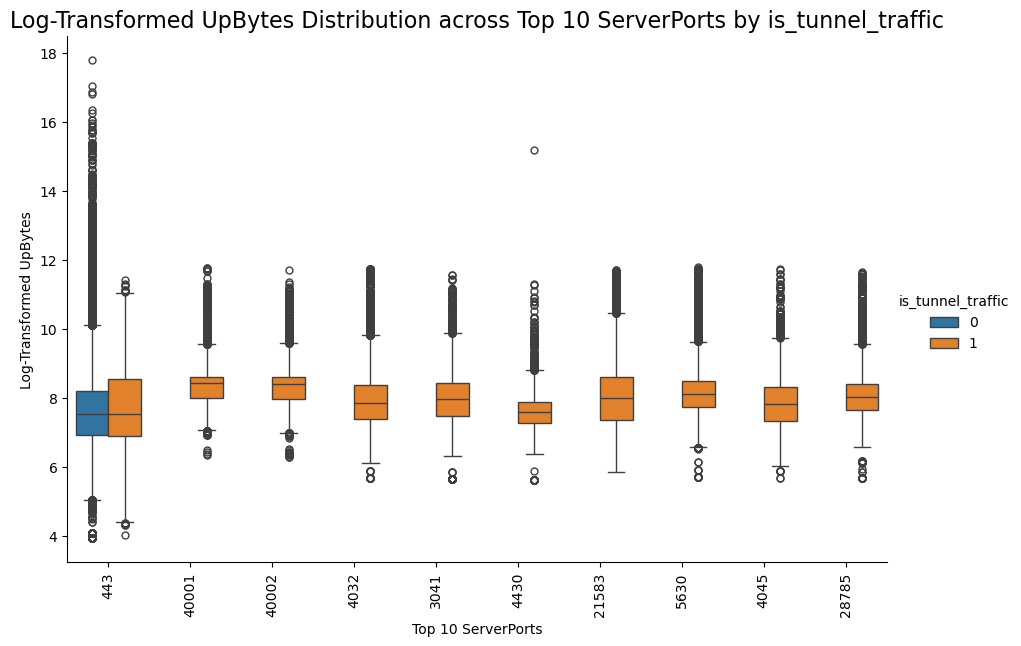

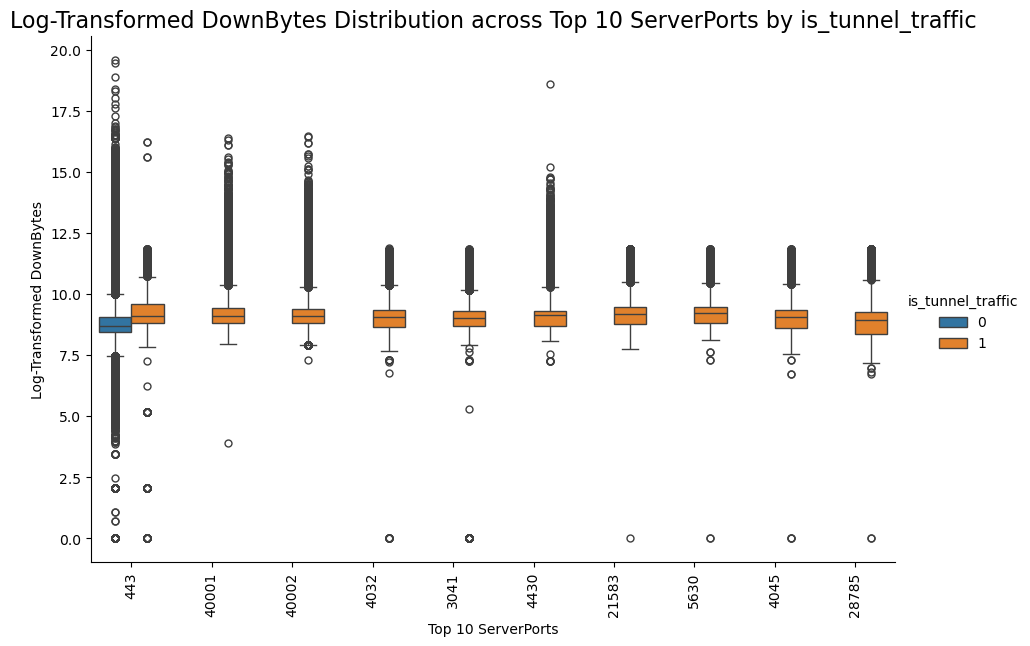

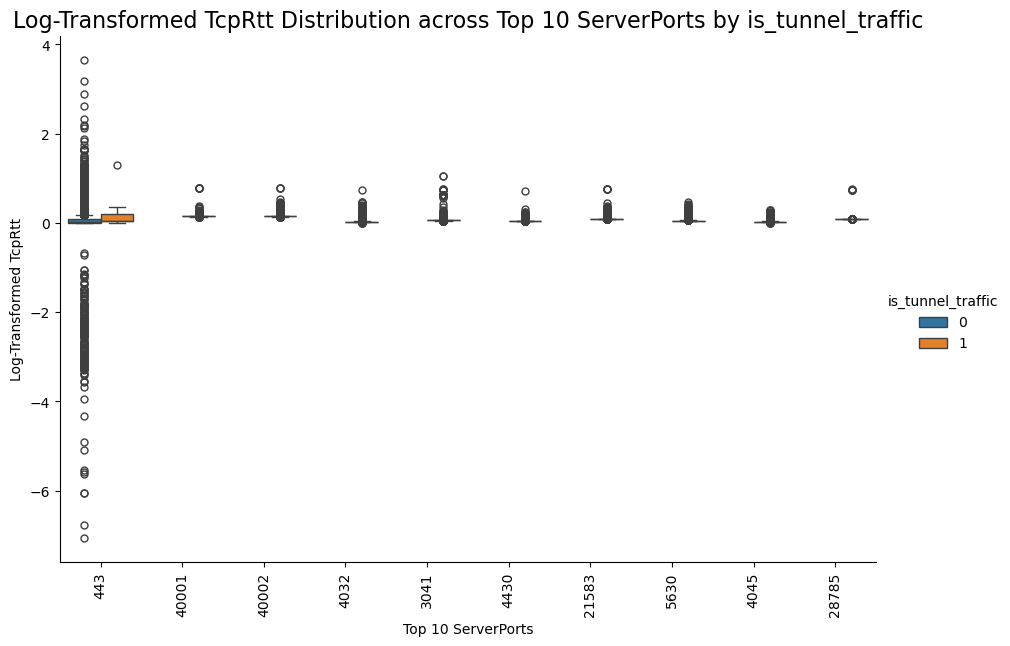

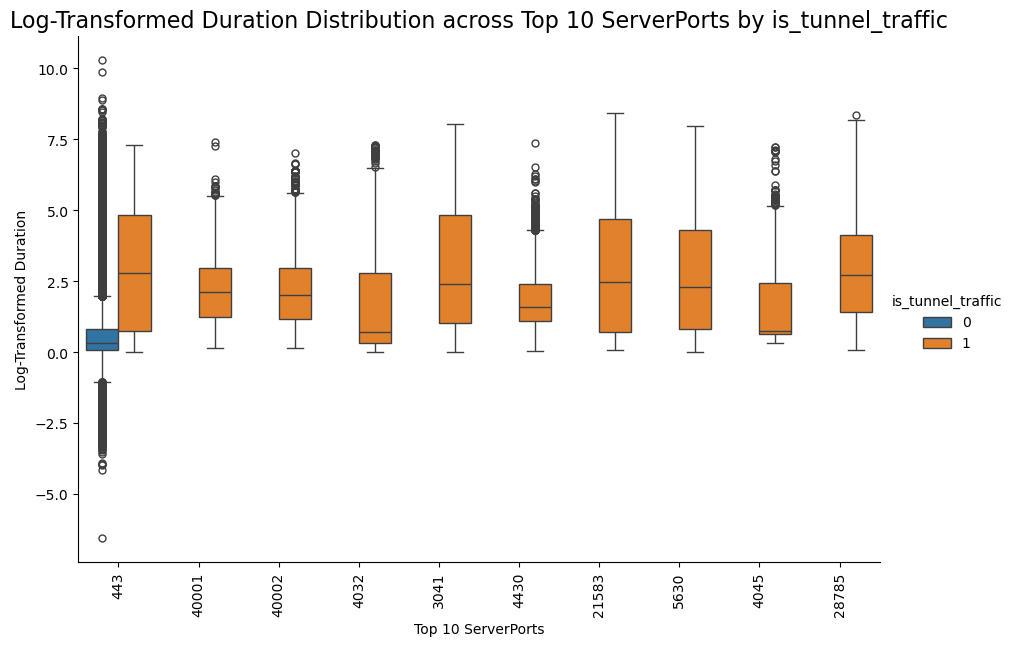

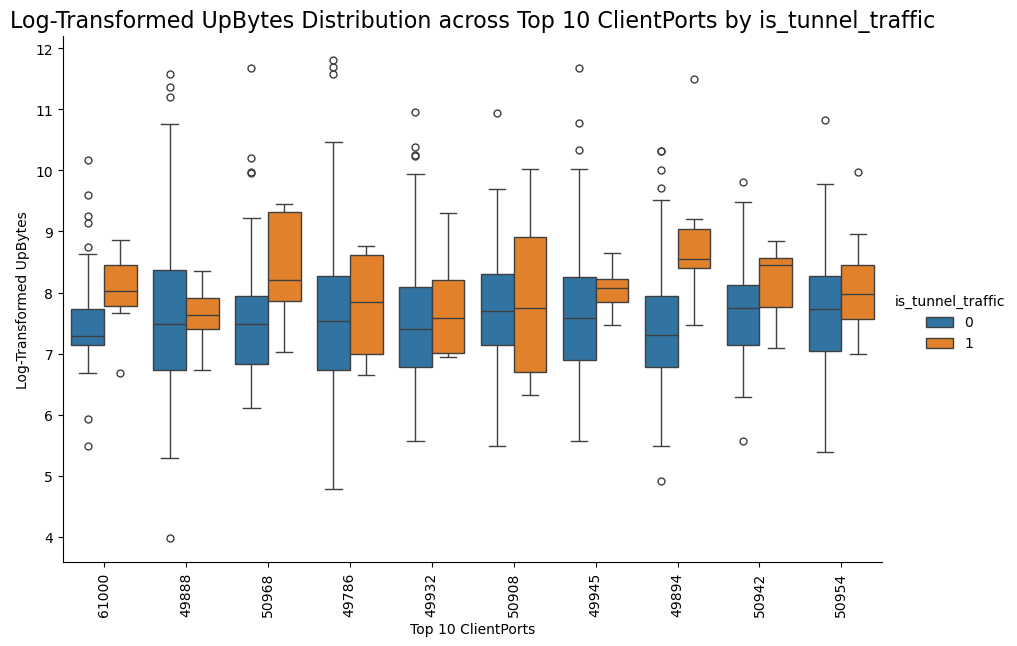

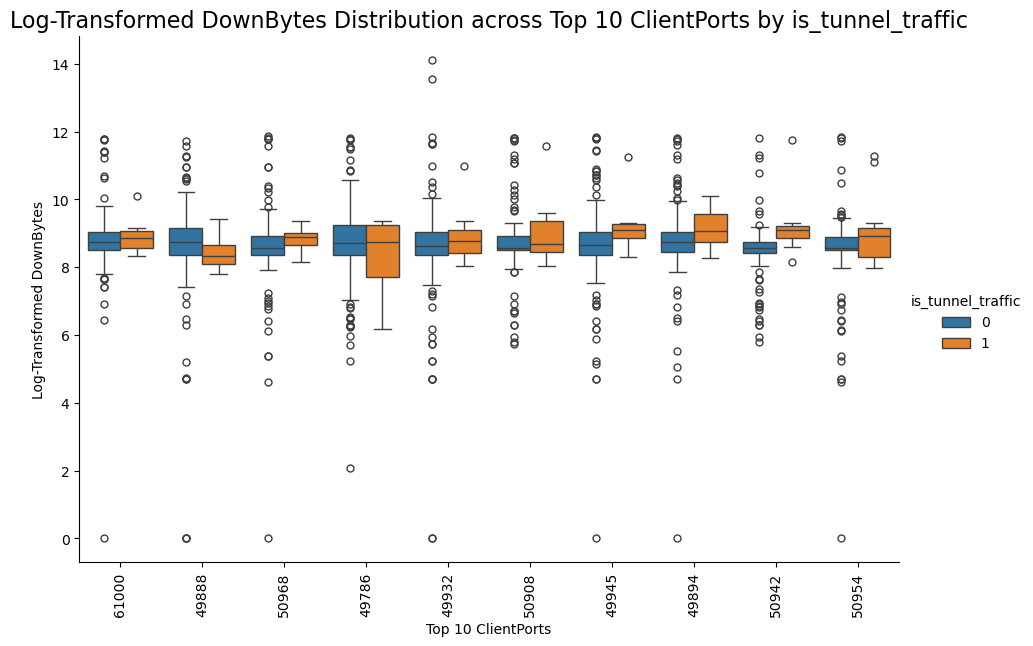

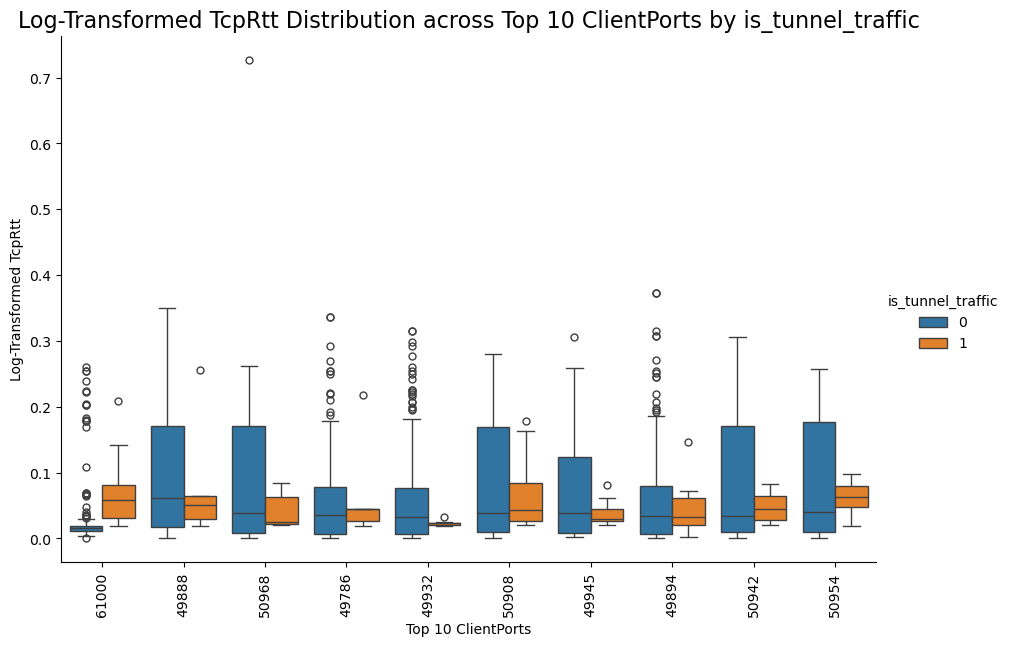

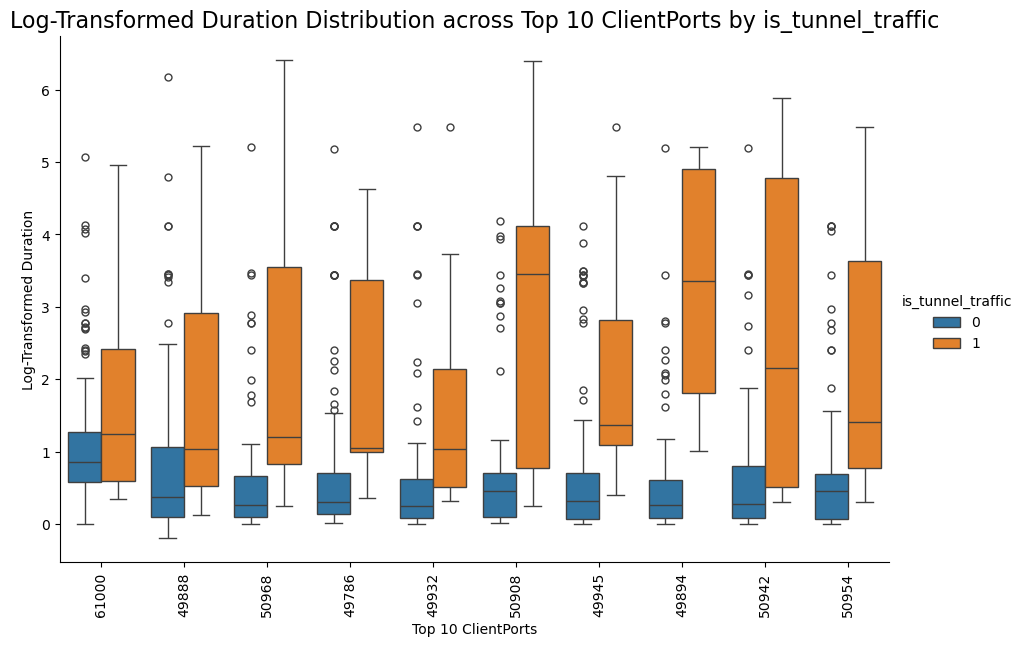

In [45]:
# define categorical and continuous variables
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values in each categorical variable for readability in plots
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values and apply log transformation to continuous variables
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    top_values = df[var].value_counts().nlargest(top_n_values).index
    filtered_df = df[df[var].isin(top_values)].copy()
    # apply log transformation to continuous variables to handle skewness
    for cont_var in continuous_vars:
        filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x) to handle zero values
    # store the filtered DataFrame and the order for x-axis
    filtered_dfs[var] = (filtered_df, top_values)

# iterate over each pair of categorical and continuous variables for plotting
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame and the top categories for ordering
        filtered_df, top_values = filtered_dfs.get(cat_var) 
        # if there is a filtered DataFrame, generate a box plot with hue for 'is_tunnel_traffic'
        if filtered_df is not None:
            # set the category order to top values only, to enforce spacing
            plot = sns.catplot(data=filtered_df, 
                               x=cat_var, 
                               y=cont_var, 
                               hue='is_tunnel_traffic', 
                               kind='box', 
                               height=6, 
                               aspect=1.5,
                               order=top_values)  # specify the order for x-axis categories
            # set plot title and axis labels for clarity
            plt.title(f'Log-Transformed {cont_var} Distribution across Top 10 {cat_var}s by is_tunnel_traffic', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Log-Transformed {cont_var}')
            # rotate x-axis labels 90 degrees for readability and avoid crowding
            for ax in plot.axes.flat:
                ax.tick_params(axis='x', rotation=90)
            # display the plot
            plt.show()

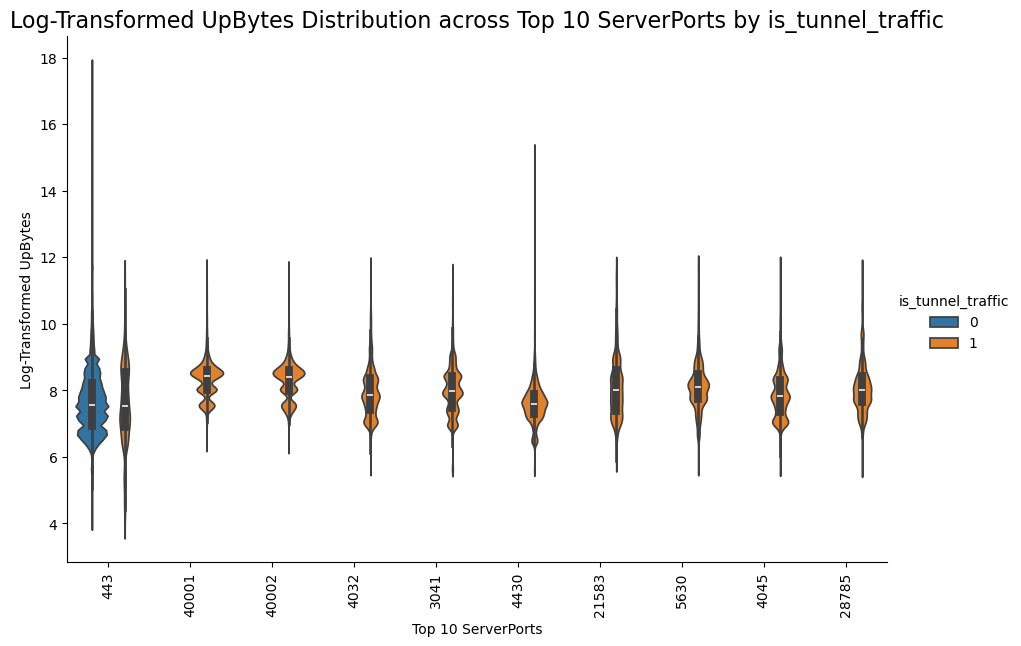

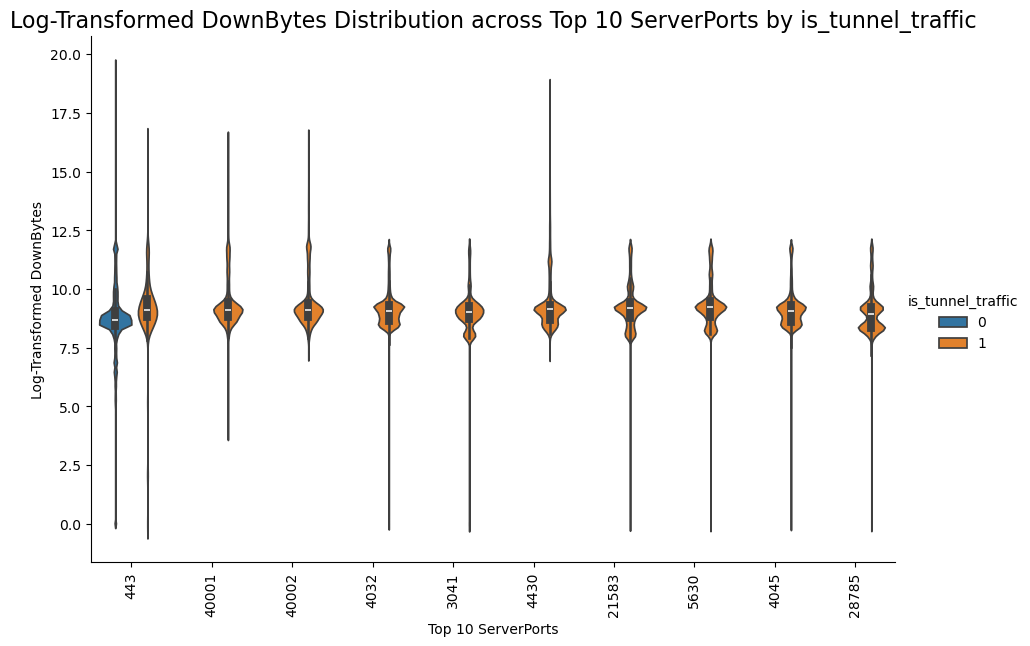

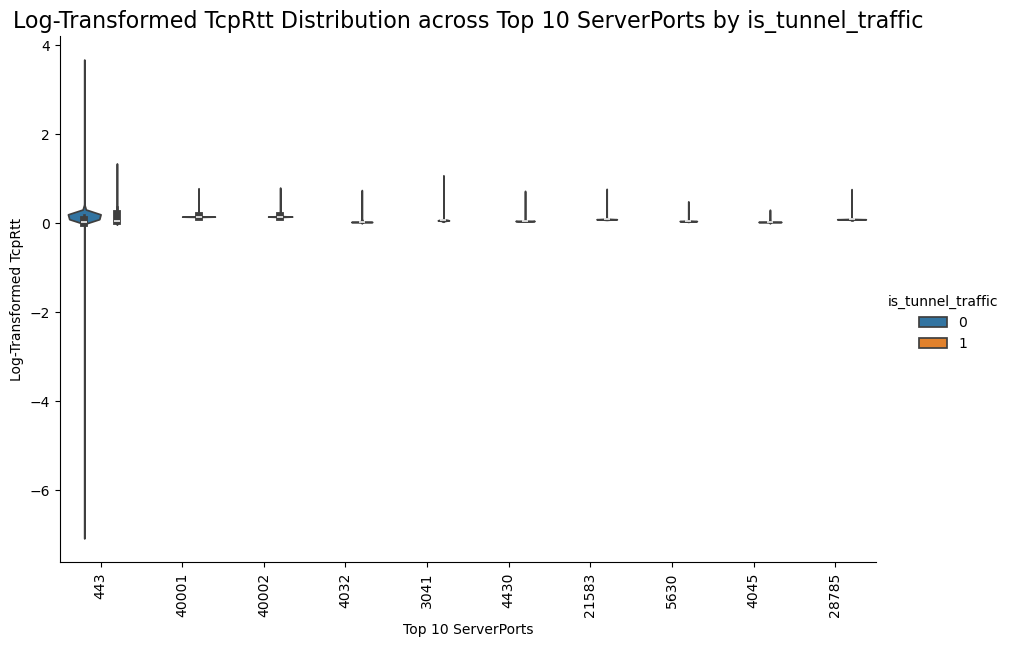

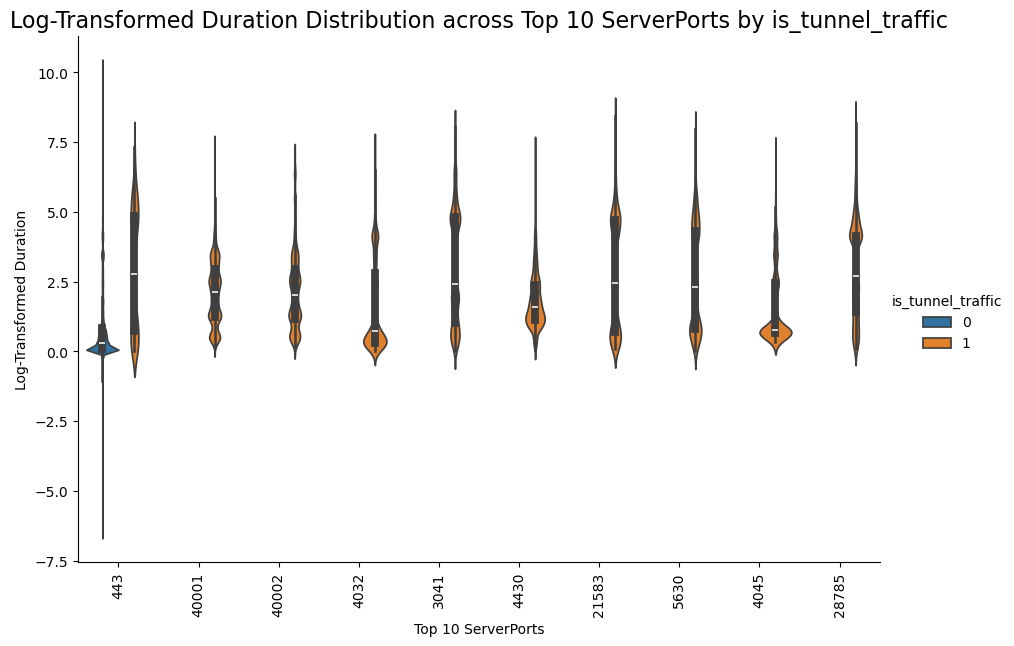

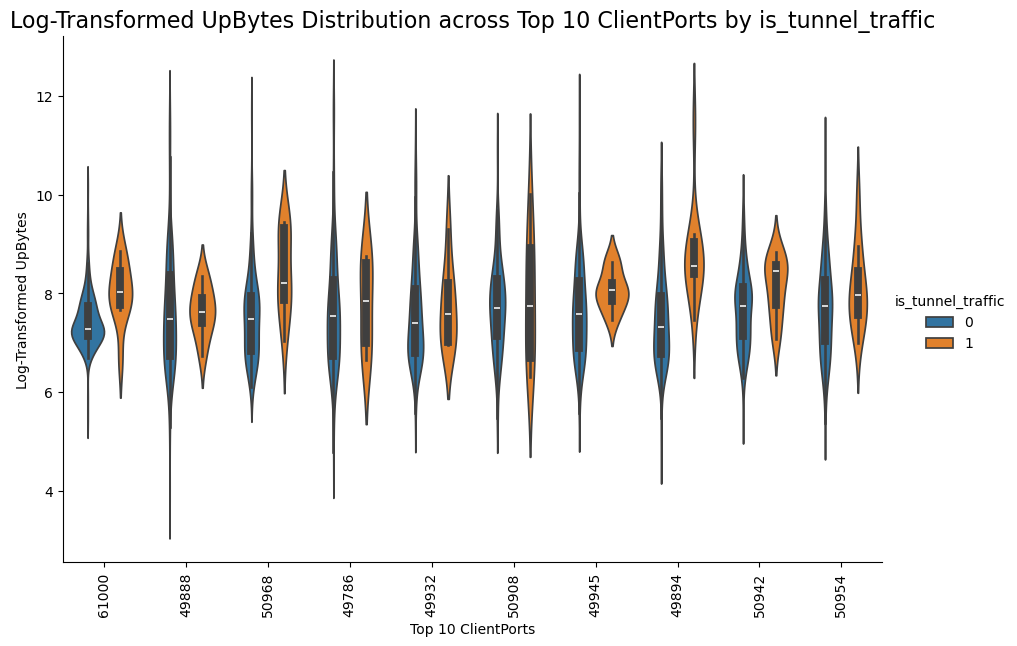

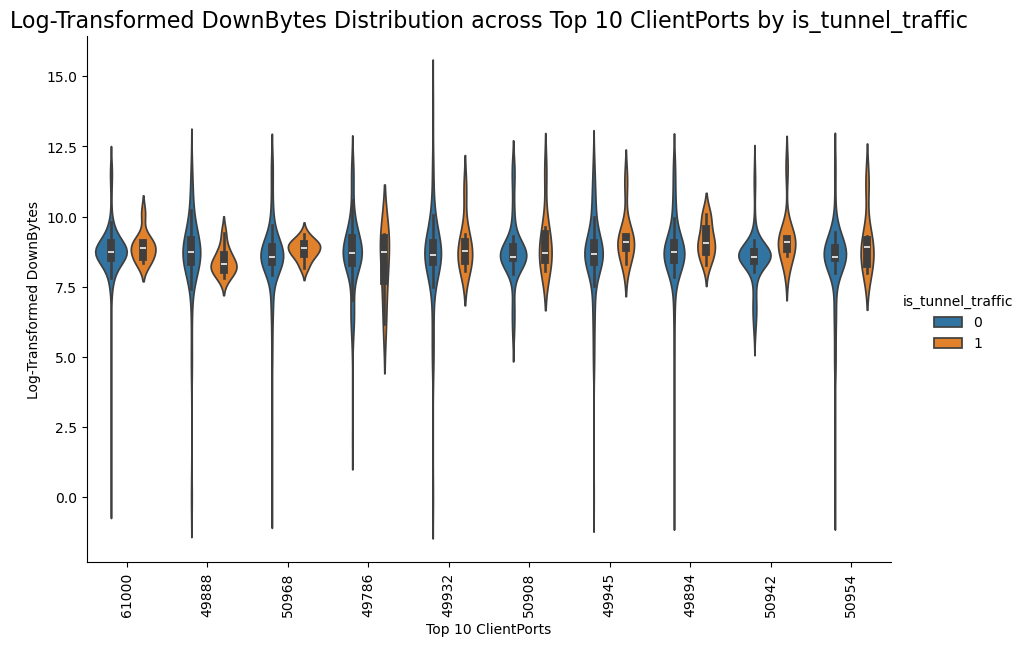

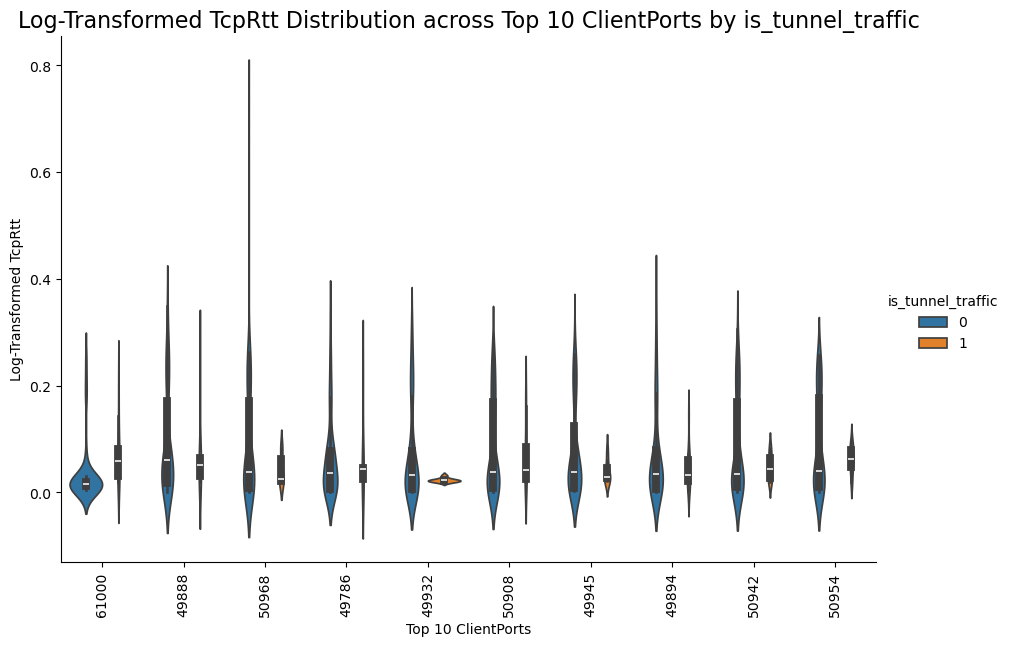

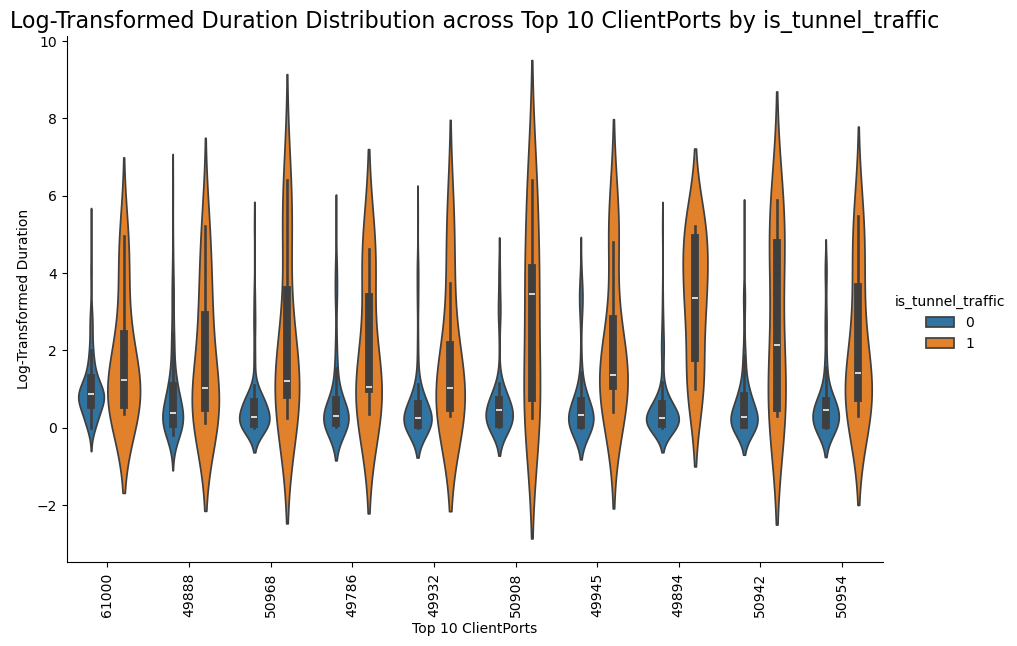

In [46]:
# define categorical and continuous variables
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values in each categorical variable for readability in plots
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values and apply log transformation to continuous variables
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    top_values = df[var].value_counts().nlargest(top_n_values).index
    filtered_df = df[df[var].isin(top_values)].copy()
    # apply log transformation to continuous variables to handle skewness
    for cont_var in continuous_vars:
        filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x) to handle zero values
    # store the filtered DataFrame and the order for x-axis
    filtered_dfs[var] = (filtered_df, top_values)

# iterate over each pair of categorical and continuous variables for plotting
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame and the top categories for ordering
        filtered_df, top_values = filtered_dfs.get(cat_var)
        # if there is a filtered DataFrame, generate a box plot with hue for 'is_tunnel_traffic'
        if filtered_df is not None:
            # set the category order to top values only, to enforce spacing
            plot = sns.catplot(data=filtered_df, 
                               x=cat_var, 
                               y=cont_var, 
                               hue='is_tunnel_traffic', 
                               kind='violin', 
                               height=6, 
                               aspect=1.5,
                               order=top_values)  # specify the order for x-axis categories
            # set plot title and axis labels for clarity
            plt.title(f'Log-Transformed {cont_var} Distribution across Top 10 {cat_var}s by is_tunnel_traffic', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Log-Transformed {cont_var}')
            # rotate x-axis labels 90 degrees for readability and avoid crowding
            for ax in plot.axes.flat:
                ax.tick_params(axis='x', rotation=90)
            # display the plot
            plt.show()

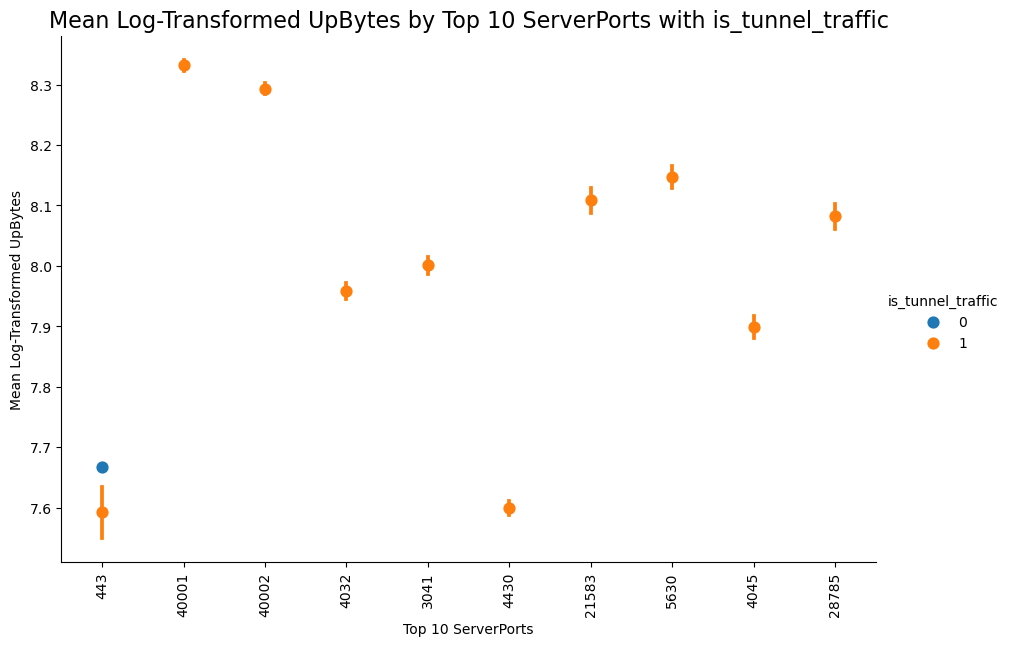

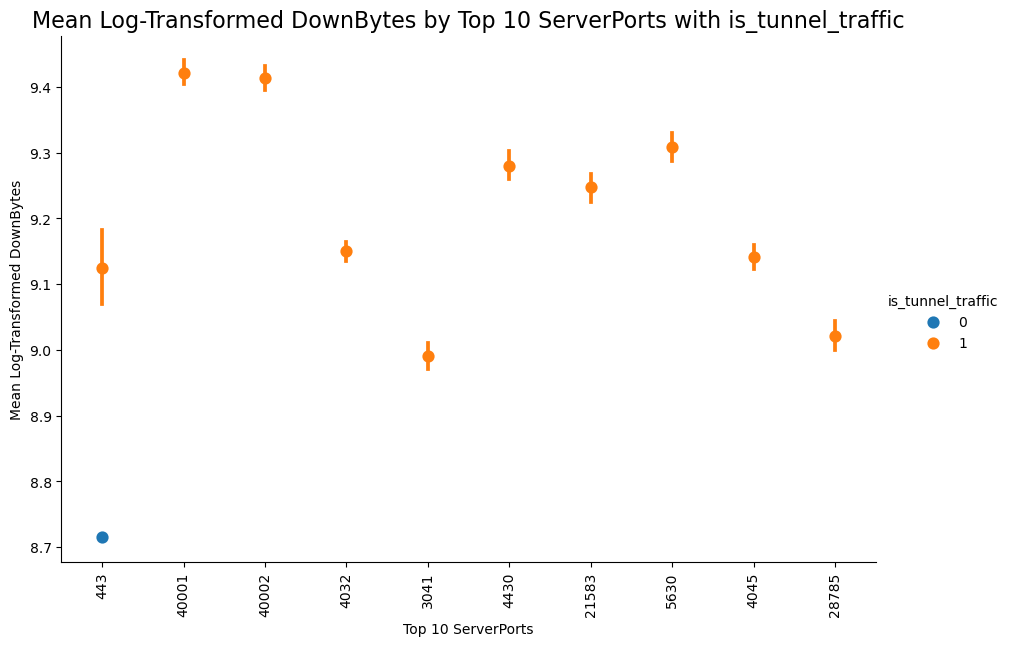

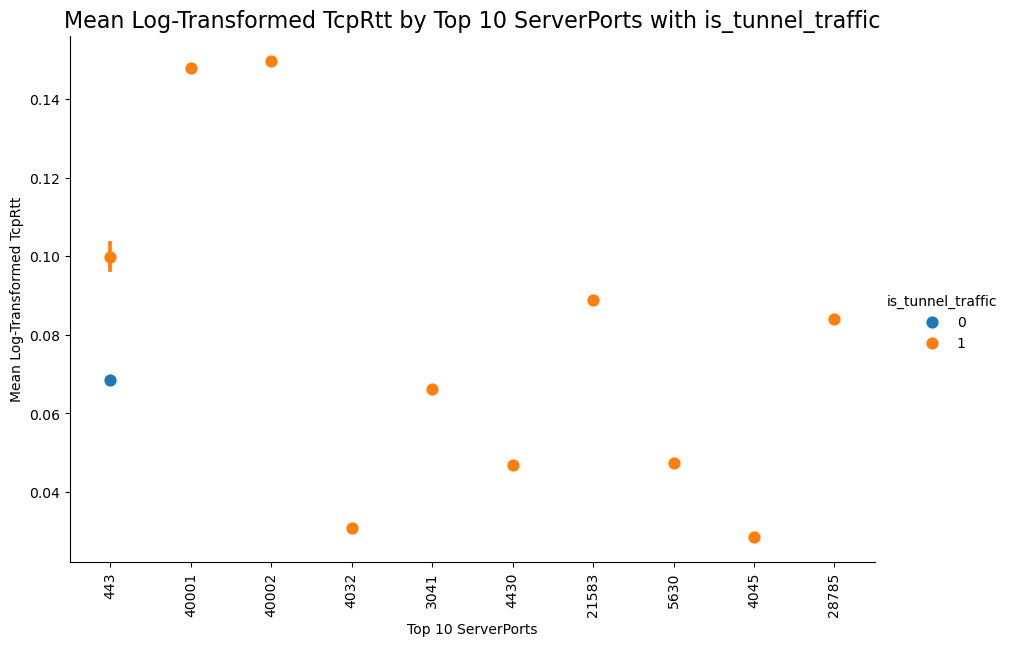

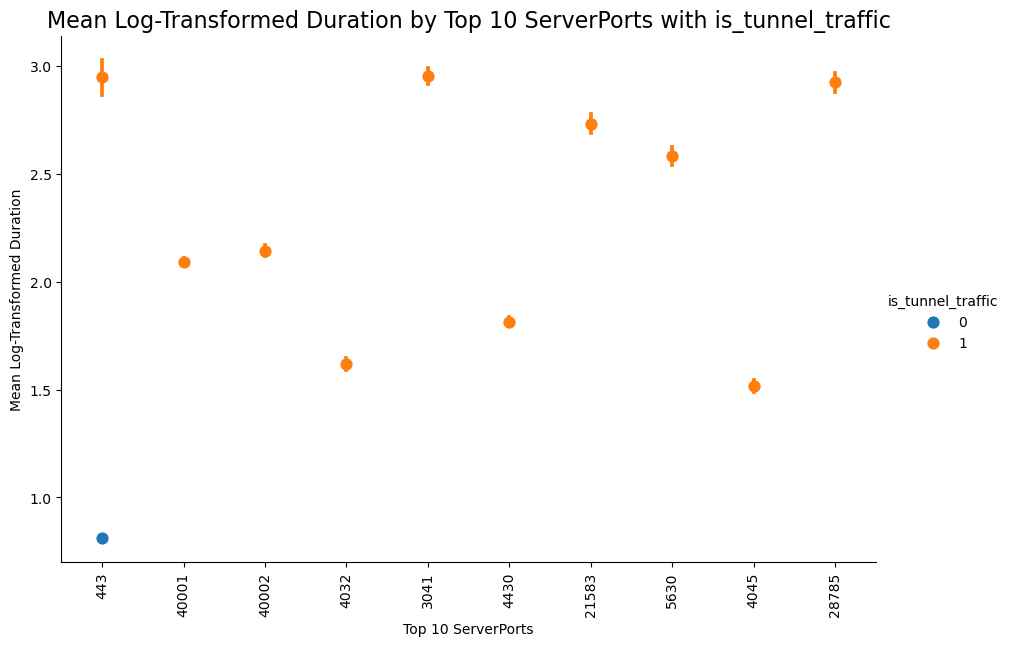

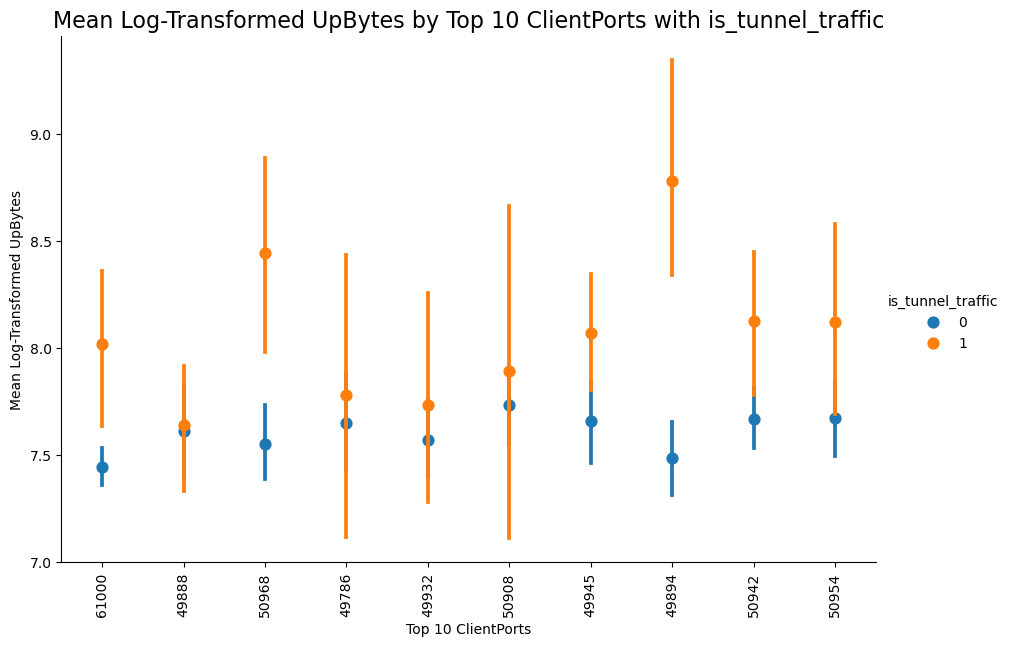

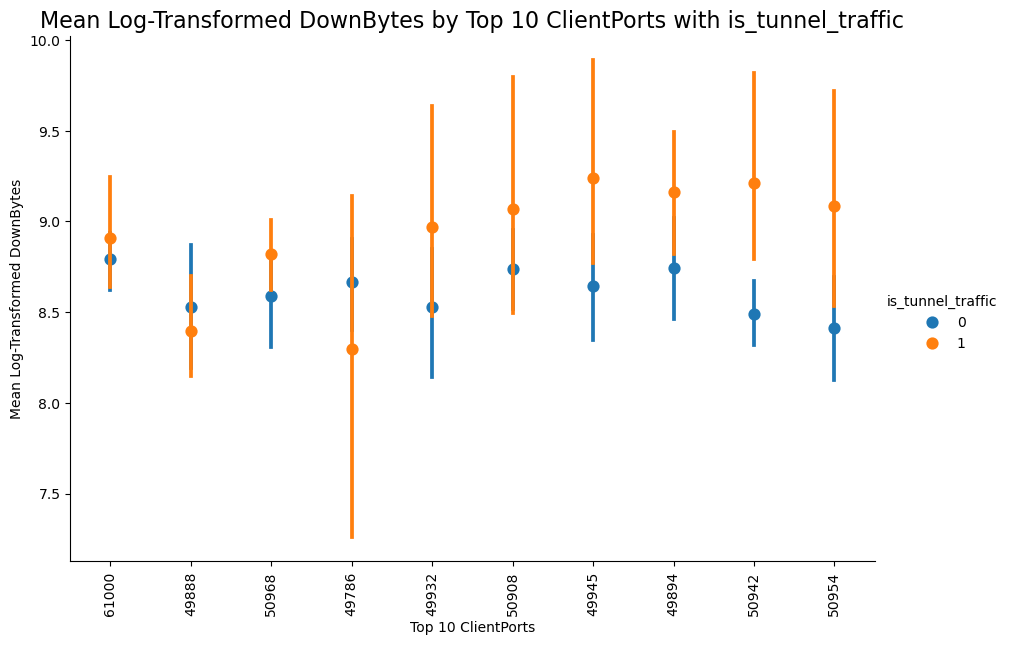

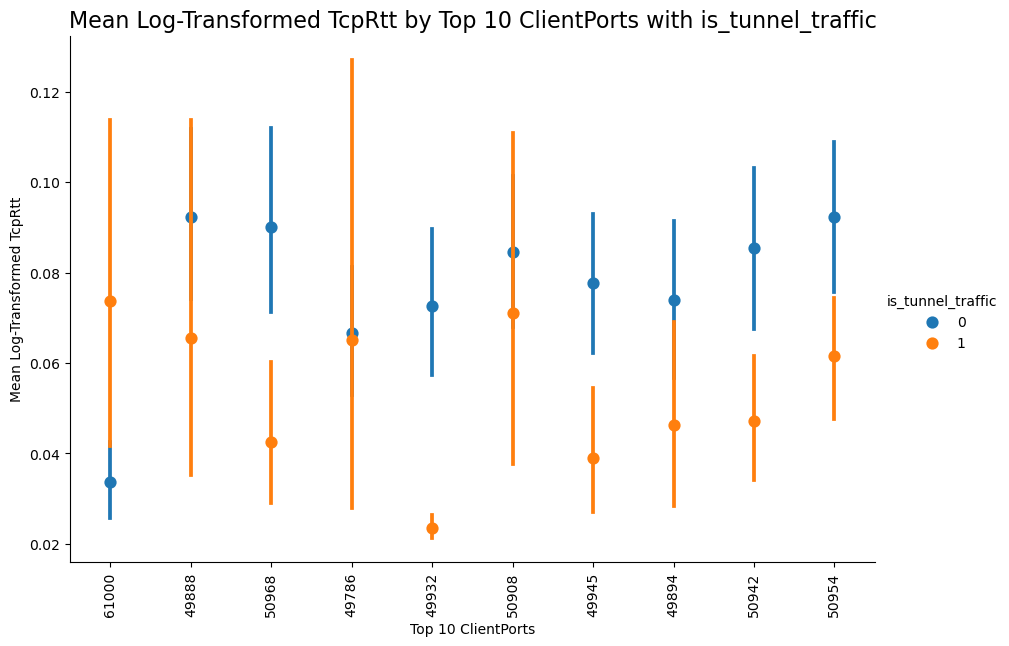

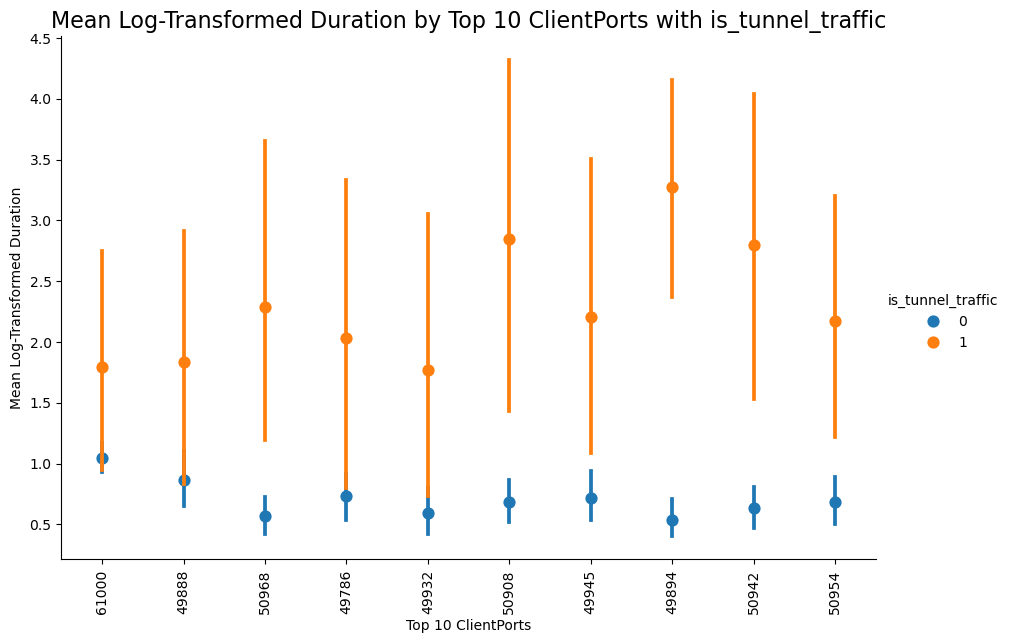

In [47]:
# define categorical and continuous variables
categorical_vars = [var for var in df.select_dtypes(include=['object', 'category']).columns if var != 'is_tunnel_traffic']
continuous_vars = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var != 'is_tunnel_traffic']

# set the limit for the top N values in each categorical variable for readability in plots
top_n_values = 10

# create a dictionary to store filtered DataFrames for each categorical variable
filtered_dfs = {}

# filter each categorical variable to include only its top N most frequent values and apply log transformation to continuous variables
for var in categorical_vars:
    # keep only the top N values for the current categorical variable
    top_values = df[var].value_counts().nlargest(top_n_values).index
    filtered_df = df[df[var].isin(top_values)].copy()
    # apply log transformation to continuous variables to handle skewness
    for cont_var in continuous_vars:
        filtered_df[cont_var] = np.log1p(filtered_df[cont_var])  # log1p(x) = log(1 + x) to handle zero values
    # store the filtered DataFrame and the order for x-axis
    filtered_dfs[var] = (filtered_df, top_values)

# iterate over each pair of categorical and continuous variables for plotting
for cat_var in categorical_vars:
    for cont_var in continuous_vars:
        # retrieve the filtered DataFrame and the top categories for ordering
        filtered_df, top_values = filtered_dfs.get(cat_var)
        # if there is a filtered DataFrame, generate a box plot with hue for 'is_tunnel_traffic'
        if filtered_df is not None:
            # set the category order to top values only, to enforce spacing
            plot = sns.catplot(data=filtered_df, 
                               x=cat_var, 
                               y=cont_var, 
                               hue='is_tunnel_traffic', 
                               kind='point', 
                               linestyles='',
                               height=6, 
                               aspect=1.5,
                               order=top_values)  # specify the order for x-axis categories
            # set plot title and axis labels for clarity
            plt.title(f'Mean Log-Transformed {cont_var} by Top 10 {cat_var}s with is_tunnel_traffic', fontsize=16)
            plt.xlabel(f'Top 10 {cat_var}s')
            plt.ylabel(f'Mean Log-Transformed {cont_var}')
            # rotate x-axis labels 90 degrees for readability and avoid crowding
            for ax in plot.axes.flat:
                ax.tick_params(axis='x', rotation=90)
            # display the plot
            plt.show()

## Formulas

In [48]:
formulas = ['is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration',
            'is_tunnel_traffic ~ UpBytes + DownBytes * TcpRtt + Duration',
            'is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt * Duration']

In [49]:
import gc

In [50]:
import warnings

In [51]:
import statsmodels.formula.api as smf

In [52]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [53]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
import pickle

In [56]:
from statsmodels.tools.sm_exceptions import PerfectSeparationError

In [57]:
continuous_vars = ['UpBytes', 'DownBytes', 'TcpRtt', 'Duration']

In [58]:
target = 'is_tunnel_traffic'

In [59]:
def evaluate_logistic_models(df, formula, use_scaler=False):
    """
    Evaluates multiple logistic regression models using different formulas on a dataset.
    
    Params:
        df: object
        formula: str
        use_scaler: bool, optional
    
    Returns:
        tuple
    """
    # train-test split with stratified sampling
    X = df.drop(columns='is_tunnel_traffic')
    y = df['is_tunnel_traffic']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=101)
    
    # combine X_train and y_train into a single DataFrame for statsmodels
    train_data = pd.concat([X_train, y_train], axis=1)

    # stratified k-fold cross-validation with limited splits for memory efficiency
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # create empty lists
    accuracy_scores = []  # store accuracy scores for each fold
    roc_auc_scores = []   # store ROC AUC scores for each fold
    
    # iterate over cross-validation splits
    for train_index, val_index in skf.split(X_train, y_train):
        train_fold = train_data.iloc[train_index].copy()
        val_fold = train_data.iloc[val_index].copy()
        # apply scaling within each fold if use_scaler is True
        if use_scaler:
            scaler = StandardScaler()
            train_fold[continuous_vars] = scaler.fit_transform(train_fold[continuous_vars])
            val_fold[continuous_vars] = scaler.transform(val_fold[continuous_vars])
        try:
            # fit model on train fold
            model = smf.logit(formula, data=train_fold)
            result = model.fit(disp=0)  # suppress output 
            # predict on validation fold
            predictions = result.predict(val_fold)
            predicted_classes = (predictions > 0.5).astype(int)
            # calculate metrics
            accuracy = accuracy_score(val_fold['is_tunnel_traffic'], predicted_classes)
            roc_auc = roc_auc_score(val_fold['is_tunnel_traffic'], predictions)
            # append scores for current fold
            accuracy_scores.append(accuracy)
            roc_auc_scores.append(roc_auc)
        except (np.linalg.LinAlgError, PerfectSeparationError) as e:
            # catch singular matrix errors or perfect separation errors and skip formula
            print(f'Skipping formula due to error: {formula} -> {e}')
            return None, None, None
        except Exception as e:
            print(f'Unexpected error with formula {formula}: {e}')
            return None, None, None
        
        # clear unused objects from memory
        gc.collect()

    # only proceed if the model completed all folds without errors
    if len(accuracy_scores) == skf.get_n_splits():
        avg_accuracy = np.mean(accuracy_scores)  # average accuracy across folds
        avg_roc_auc = np.mean(roc_auc_scores)    # average ROC AUC across folds
        print(f'Formula: {formula}')
        print(f'Average Accuracy: {avg_accuracy:.3f}, Average ROC AUC: {avg_roc_auc:.3f}\n')

        # save the trained model to disk
        with open('best_logistic_model.pkl', 'wb') as f:
            pickle.dump(result, f)
        
        # test the model on the test set
        if use_scaler:
            X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])
        test_predictions = result.predict(X_test)
        test_predicted_classes = (test_predictions > 0.5).astype(int)
        test_accuracy = accuracy_score(y_test, test_predicted_classes)
        test_roc_auc = roc_auc_score(y_test, test_predictions)
        
        # return the trained model and test metrics
        return result, test_accuracy, test_roc_auc
    else:
        print('Model could not complete all folds successfully.')
        return None, None, None

## Evaluate Logistic Models
* The best model for predicting is_tunnel_traffic is the straightforward formula is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration, which achieves an average accuracy of 0.874 and the highest ROC AUC of 0.752. This model avoids interaction terms that introduce instability and overflow warnings in the other models, maintaining reliable performance and better discrimination between tunnel and non-tunnel traffic. The simplicity and stability of this model, combined with its competitive ROC AUC, make it the most effective choice for this classification task.

In [60]:
# variables to store the best model and metrics
best_model = None
best_test_accuracy = 0
best_test_roc_auc = 0
best_formula = None

# loop over each formula, evaluating each model and keeping the best one
for formula in formulas:
    print(f'Evaluating Formula: {formula}')
    # call the function with the current formula
    model, test_accuracy, test_roc_auc = evaluate_logistic_models(df, 
                                                                  formula=formula, 
                                                                  use_scaler=True)
    # check if this model is the best based on ROC AUC and accuracy
    if model is not None and (test_roc_auc > best_test_roc_auc or 
                             (test_roc_auc == best_test_roc_auc and test_accuracy > best_test_accuracy)):
        best_model = model
        best_test_accuracy = test_accuracy
        best_test_roc_auc = test_roc_auc
        best_formula = formula

# output the best results
print(f'\nBest Formula: {best_formula}')
print(f'Best Test Set Accuracy: {best_test_accuracy:.3f}')
print(f'Best Test Set ROC AUC: {best_test_roc_auc:.3f}')

Evaluating Formula: is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration
Formula: is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration
Average Accuracy: 0.874, Average ROC AUC: 0.752

Evaluating Formula: is_tunnel_traffic ~ UpBytes + DownBytes * TcpRtt + Duration


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Formula: is_tunnel_traffic ~ UpBytes + DownBytes * TcpRtt + Duration
Average Accuracy: 0.874, Average ROC AUC: 0.724

Evaluating Formula: is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt * Duration


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Formula: is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt * Duration
Average Accuracy: 0.874, Average ROC AUC: 0.689


Best Formula: is_tunnel_traffic ~ UpBytes + DownBytes + TcpRtt + Duration
Best Test Set Accuracy: 0.873
Best Test Set ROC AUC: 0.753


## Perform Inference 
* In this inference example, a previously saved logistic regression model (best_logistic_model.pkl) is loaded to predict the is_tunnel_traffic class for new sample data. The sample data includes three entries with attributes such as ServerPort, ClientPort, UpBytes, DownBytes, TcpRtt, and Duration. Although scaling is an option, it was not applied here as indicated by use_scaler = False. The model predicts probabilities for each entry, which are then converted to binary class predictions (1 for tunnel traffic, 0 for non-tunnel traffic) based on a 0.5 threshold. The predictions are [1, 0, 0], indicating that the model classifies the first entry as tunnel traffic while the remaining two are classified as non-tunnel traffic. Despite this, a runtime warning regarding overflow in the logistic function hints at potential numerical stability issues.

In [61]:
# load the model for inference, provide sample data and predict
if best_model is not None:
    with open('best_logistic_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    # sample new_data DataFrame for inference
    new_data = pd.DataFrame({
        'ServerPort': ['80', '443', '8080'],
        'ClientPort': ['52345', '49152', '62485'],
        'UpBytes': [1200, 45000, 300],
        'DownBytes': [1500, 53000, 700],
        'TcpRtt': [0.032, 0.089, 0.043],
        'Duration': [600.5, 85.0, 43.0]
    })
    # scale new_data if scaler was used
    use_scaler = False
    if use_scaler:
        new_data[continuous_vars] = scaler.transform(new_data[continuous_vars])
    # use the loaded model for inference on new_data
    loaded_predictions = loaded_model.predict(new_data)
    loaded_predicted_classes = (loaded_predictions > 0.5).astype(int)
    print('Loaded Model Predicted Classes:\n', loaded_predicted_classes.tolist())

Loaded Model Predicted Classes:
 [1, 0, 0]


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
